# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

#### Common code for the assignment ####

In [0]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import sqlite3
import pandas as pd
import numpy as np


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle

"""
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
"""





class assign7RBF:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])
        self.svm_clf = None
        self.rbf_C = []
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}

        
    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def SVM_alpha (self):
        return self._SVM_alpha

    @SVM_alpha.setter
    def SVM_alpha (self,new_SVM_alpha):
        self._SVM_alpha = new_SVM_alpha

    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval


    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
        
    def load_data(self,mltype):
        f1name = 'E:/appliedaiacourse/assignments/dblite/svm'
        if mltype == 'BOW':
            fname1 = f1name + '/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/bowvectorizer/y_train'
            fname6 = f1name + '/bowvectorizer/y_test'
            fname7 = f1name + '/bowvectorizer/ytrain'
            fname8 = f1name + '/bowvectorizer/yval'
        elif mltype == 'TFIDF':
            fname1 = f1name + '/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfvectorizer/y_train'
            fname6 = f1name + '/tfidfvectorizer/y_test'
            fname7 = f1name + '/tfidfvectorizer/ytrain'
            fname8 = f1name + '/tfidfvectorizer/yval'        
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/avgw2vectorizer/y_train'
            fname6 = f1name + '/avgw2vectorizer/y_test'
            fname7 = f1name + '/avgw2vectorizer/ytrain'
            fname8 = f1name + '/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/tfidfwtw2vectorizer/yval'                

        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)


    
    def SVMClasifier(self):
        self.svm_clf= SVC(kernel='rbf',class_weight={0:5.14,1:1},max_iter=1000,\
                          tol=1e-3, verbose=100,random_state=42)
        return self.svm_clf
    
    def getSVMClasifier(self):
        return self.svm_clf
    
    @property
    def svm_clf(self):
        return self._svm_clf
    
    @svm_clf.setter
    def svm_clf(self,new_svm_clf):
        self._svm_clf = new_svm_clf
        
    #set alpha parameter for classifier
    def setCparm(self,prmval):
        params = {'C': prmval}
        (self.svm_clf).set_params(**params)
        print(self.svm_clf)
        return self.svm_clf    
    
    def SVM_hyperparamtuning(self,measure,cvfold=5,verbose=100):
        
        # setting two parameter values for tuning
        param_grid = {'C':[10 ** x for x in range (-4,4)]}
        
        cvfold=5
        vbose=100
        #get the classifier
        grdsch_clf = self.getSVMClasifier()
        grdschcv = GridSearchCV(grdsch_clf,param_grid,scoring=measure,cv=cvfold, verbose=vbose)
        
        #fit the data with the classifier
        grdschcv.fit(self.X_train,self.y_train)
        
        return [grdschcv.best_score_,grdschcv.best_params_,grdschcv]    
    
    def SVM_calcrocaucscore(self,endval):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process             
        """
        alpha_start = 0.0000001
        
        trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        while(alpha_start <= endval):
            
            # set alpha param for classifier
            self.setCparm(alpha_start)
            
            # fit the x-train model            
            (self.svm_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts
                              )
            my_calib = CalibratedClassifierCV((self.svm_clf),method='sigmoid',cv='prefit')
            my_calib.fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
            
            self.yprdprobatrn =  (my_calib).predict_proba(self.xtrain)[:,1]            
            (self.rocaucscoretrn).append(roc_auc_score(self.ytrain,self.yprdprobatrn))
            print('Fitting probability generation and roc auc score generation for training data complete...')

            #fit the validation model
            (self.svm_clf).fit(self.xval,self.yval,sample_weight=val_smp_wts)
            
            my_calib_1 = CalibratedClassifierCV((self.svm_clf),method='sigmoid',cv='prefit')
            my_calib_1.fit(self.xval,self.yval,sample_weight=val_smp_wts)
            
            self.yprdprobaval =  (my_calib_1).predict_proba(self.xval)[:,1]
            (self.rocaucscoreval).append(roc_auc_score(self.yval,self.yprdprobaval))
            print('Fitting probability generation and roc auc score generation for validation data complete...')
            
            #set alpha to the next value
            (self.rbf_C).append(alpha_start)
            alpha_start = alpha_start * 10
            
        print('Function exiting...')
    def SVM_actualClasifier(self,parm_alpha):
        
        """
            this function uses CalibratedClasifierCV for prediciting probabilities
            this is an imbalanced dataset hence we are using class weights and 
            sample weights in the fit process            
        """
        train_clf = self.SVMClasifier()
        test_clf = self.SVMClasifier()
        
        params = {'C': parm_alpha}
        (train_clf).set_params(**params) 
        
        #compute all the sanple weughts
        trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        train_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.y_train)
        test_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.y_test)
        
        # fit train again and predict probabilites  from xtrain 
        (train_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        
        #Calibratedcv for predicting probabilities        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        
        # fit train with sample weights
        my_calib_1.fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        
        # predict probabilites using predict_proba  from calibratedcv
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        
        # compute the false-positive r, true positive rates and thresholds
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # cailbratedCv for validation dataset
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        #fit the validation dataset with sample weights
        my_calib_2.fit(self.xval,self.yval,sample_weight=val_smp_wts)
        
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)        
        
        # calculate accuracy_score for validation dataset
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        (test_clf).fit(self.X_train,self.y_train,sample_weight=train_smp_wts)        
        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        
        #predicting probabilities for X_test setweights test sample weights
        my_calib.fit(self.X_test,self.y_test,sample_weight=test_smp_wts)        
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print('***X_test predict',self.test_predict)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        #calculate accuracy_score for X_test
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report for X_test
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        
        print('*** predict probabilities***',self.ytst_predprob_actclf)
              
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.sgd_clf = test_clf
        
    def SVM_actualClasifier_0(self,parm_alpha):
        
        """
            this fn uses calibratedclassiferCV to predict and get the predicted probabilities
        """
        
        self.setCparm(parm_alpha)
        (self.svm_clf).fit(self.X_test,self.y_test)
        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((self.svm_clf),method='sigmoid',cv='prefit')
        my_calib.fit(self.X_test,self.y_test)
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        #store the classifier parameters
        self.clasify_params['clfparams'] = (self.svm_clf).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report 
        #classification_report(self.ytest, self.test_predict)
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # fit train again and predict probabilites  from xtrain 
        (self.svm_clf).fit(self.xtrain,self.ytrain)
        my_calib_1 = CalibratedClassifierCV((self.svm_clf),method='sigmoid',cv='prefit')
        my_calib_1.fit(self.xtrain,self.ytrain)
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.X_train)[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.y_train, self.ytrn_predprob_actclf)
        
        #fit the validation model predict and generate the accuracy score        
        (self.svm_clf).fit(self.xval,self.yval)        
        my_calib_2 = CalibratedClassifierCV((self.svm_clf),method='sigmoid',cv='prefit')
        my_calib_2.fit(self.xval,self.yval)
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)

        # calculate accuracy_score
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test        
        """
        if __name__ == '__main__':
            lnrsvm = assign7SVM()
            lnrsvm.load_data('BOW')
            lnrsvm.load_data('TFIDF')
            lnrsvm.load_data('AVGW2V')
            lnrsvm.load_data('WTW2V')
            ret_grdschcv = lnrsvm.hyperparamtuning('roc_auc')
            print(ret_grdschcv[0])
            print(ret_grdschcv[1])
            print(ret_grdschcv[2])
        """

In [0]:
import warnings
warnings.filterwarnings("ignore")

from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight

import sqlite3
import pandas as pd
import numpy as np


import string
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import os
import pickle

class assign7SVM:
    
    def __init__(self):
        self.X_train=pd.DataFrame()
        self.X_test=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.y_train= pd.Series([])
        self.ytrain= pd.Series([])
        self.y_test= pd.Series([])
        self.yval= pd.Series([])
        self.sgd_clf = None
        self.SVM_alpha = []
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []        
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.feat_names = []

        
    #data for gridseatch
    @property
    def X_train(self):
        return self._X_train
    
    @X_train.setter
    def X_train(self,new_X_train):
        self._X_train = new_X_train        

    #unseen data for testing
    @property
    def X_test(self):
        return self._X_test
    
    @X_test.setter
    def X_test(self,new_X_test):
        self._X_test = new_X_test

    #data for roc_auc_score
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain
        
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def y_train(self):
        return self._y_train
    
    @y_train.setter
    def y_train(self,new_y_train):
        self._y_train = new_y_train

    @property
    def y_test(self):
        return self._y_test
    
    @y_test.setter
    def y_test(self,new_y_test):
        self._y_test = new_y_test
        
    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
        
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval     
   
    @property
    def SVM_alpha (self):
        return self._SVM_alpha

    @SVM_alpha.setter
    def SVM_alpha (self,new_SVM_alpha):
        self._SVM_alpha = new_SVM_alpha

    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn

    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval


    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest
        
    def load_data(self,mltype):
        f1name = 'E:/appliedaiacourse/assignments/dblite/svm'
        if mltype == 'BOW':
            fname1 = f1name + '/bowvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/bowvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/bowvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/bowvectorizer/ppvectscld_xval'
            fname5 = f1name + '/bowvectorizer/y_train'
            fname6 = f1name + '/bowvectorizer/y_test'
            fname7 = f1name + '/bowvectorizer/ytrain'
            fname8 = f1name + '/bowvectorizer/yval'
            fname9 = f1name + '/bowvectorizer/bow_feat'
        elif mltype == 'TFIDF':
            fname1 = f1name + '/tfidfvectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfvectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfvectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfvectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfvectorizer/y_train'
            fname6 = f1name + '/tfidfvectorizer/y_test'
            fname7 = f1name + '/tfidfvectorizer/ytrain'
            fname8 = f1name + '/tfidfvectorizer/yval'  
            fname9 = f1name + '/tfidfvectorizer/tfidf_feat'
        elif mltype == 'AVGW2V':
            fname1 = f1name + '/avgw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/avgw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/avgw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/avgw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/avgw2vectorizer/y_train'
            fname6 = f1name + '/avgw2vectorizer/y_test'
            fname7 = f1name + '/avgw2vectorizer/ytrain'
            fname8 = f1name + '/avgw2vectorizer/yval'        
        elif mltype == 'WTW2V':
            fname1 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_train'            
            fname2 = f1name + '/tfidfwtw2vectorizer/ppvectscld_x_test'
            fname3 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xtrain'
            fname4 = f1name + '/tfidfwtw2vectorizer/ppvectscld_xval'
            fname5 = f1name + '/tfidfwtw2vectorizer/y_train'
            fname6 = f1name + '/tfidfwtw2vectorizer/y_test'
            fname7 = f1name + '/tfidfwtw2vectorizer/ytrain'
            fname8 = f1name + '/tfidfwtw2vectorizer/yval'                

        with open (fname1, 'rb') as fp:
            self.X_train = pickle.load(fp)

        with open (fname2, 'rb') as fp:
            self.X_test = pickle.load(fp)
            
        with open (fname3, 'rb') as fp:
            self.xtrain = pickle.load(fp)
            
        with open (fname4, 'rb') as fp:
            self.xval = pickle.load(fp)

        with open (fname5, 'rb') as fp:
            self.y_train = pickle.load(fp)

        with open (fname6, 'rb') as fp:
            self.y_test = pickle.load(fp)
            
        with open (fname7, 'rb') as fp:
            self.ytrain = pickle.load(fp)
            
        with open (fname8, 'rb') as fp:
            self.yval = pickle.load(fp)
            
        if (mltype == 'BOW' or mltype=='TFIDF'):
            with open (fname9, 'rb') as fp:
                self.feat_names = pickle.load(fp)            

    
    def SGDClasifier(self):
        self.sgd_clf= linear_model.SGDClassifier(loss='hinge',class_weight={0:5.14,1:1},max_iter=1000,\
                                                 tol=1e-3,verbose=100,random_state=42)
        return self.sgd_clf
    
    def getSGDClassifier(self):
        return self.sgd_clf
    
    @property
    def sgd_clf(self):
        return self._sgd_clf
    
    @sgd_clf.setter
    def sgd_clf(self,new_sgd_clf):
        self._sgd_clf = new_sgd_clf
        
    #set alpha parameter for classifier
    def setalphaparm(self,prmval):
        params = {'alpha': prmval}
        (self.sgd_clf).set_params(**params)
        print(self.sgd_clf)
        return self.sgd_clf
    
    #set penalty parameter for classifier
    def setpenaltyparm(self,prmval):
        params = {'penalty': prmval}
        (self.sgd_clf).set_params(**params)
        return self.sgd_clf
    
    #set class_weights = blanced for classifier
    def setclasswts(self,prmval):
        params = {'class_weight': prmval}  #='balanced'
        (self.sgd_clf).set_params(**params)
        return self.sgd_clf    
    
    #set n_iter parameter for classifier
    def setniterparm(self,prmval):
        params = {'n_iter': prmval}
        (self.sgd_clf).set_params(**params)
        return self.sgd_clf    

    def svm_fitdata(self):
        (self.sgd_clf).fit(self.X_test,self.y_test)
        return self.sgd_clf    
    
    
    def hyperparamtuning(self,measure,cvfold=5,verbose=100):
        
        # setting two parameter values for tuning
        param_grid = { 'penalty':['l2','l1'],
                     'alpha':[10 ** x for x in range (-4,4)]}
        cvfold=10
        vbose=100
        #get the classifier
        grdsch_clf = self.SGDClasifier()
        grdschcv = GridSearchCV(grdsch_clf,param_grid,scoring=measure,cv=cvfold, verbose=vbose)
        
        #fit the data with the classifier
        grdschcv.fit(self.X_train,self.y_train)
        
        return [grdschcv.best_score_,grdschcv.best_params_,grdschcv]
    
    
    def SVM_calcrocaucscore(self,endval):
        alpha_start = 0.0000001
        
        while(alpha_start <= endval):
            
            # set alpha param for classifier
            self.setalphaparm(alpha_start)
            
            # fit the x-train model            
            (self.sgd_clf).fit(self.xtrain,self.ytrain)
            my_calib = CalibratedClassifierCV((self.sgd_clf),method='sigmoid',cv='prefit')
            my_calib.fit(self.xtrain,self.ytrain)
            self.yprdprobatrn =  (my_calib).predict_proba(self.xtrain)[:,1]
            (self.rocaucscoretrn).append(roc_auc_score(self.ytrain,self.yprdprobatrn))
            print('Fitting probability generation and roc auc score generation for training data complete...')

            #fit the validation model
            #(self.sgd_clf).fit(self.xval,self.yval)
            my_calib_1 = CalibratedClassifierCV((self.sgd_clf),method='sigmoid',cv='prefit')
            my_calib_1.fit(self.xval,self.yval)
            self.yprdprobaval =  (my_calib_1).predict_proba(self.xval)[:,1]
            (self.rocaucscoreval).append(roc_auc_score(self.yval,self.yprdprobaval))
            print('Fitting probability generation and roc auc score generation for validation data complete...')
            
            #set alpha to the next value
            (self.SVM_alpha).append(alpha_start)
            alpha_start = alpha_start * 10
            
        print('Function exiting...')

        
    def SVM_actualClasifier(self,parm_alpha):
        
        """
            this fn uses calibratedclassiferCV to predict and get the predicted probabilities
        """
        train_clf = self.SGDClasifier()
        test_clf = self.SGDClasifier()
        
        params = {'alpha': parm_alpha}
        (train_clf).set_params(**params)      
        
        params = {'penalty': 'l2'}
        (train_clf).set_params(**params)      
        
         
        trn_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.ytrain)
        val_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.yval)
        
        # fit train again and predict probabilites  from xtrain 
        (train_clf).fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        #(self.sgd_clf).fit(self.xtrain,self.ytrain)
        
        my_calib_1 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        my_calib_1.fit(self.xtrain,self.ytrain,sample_weight=trn_smp_wts)
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        #fit the validation model predict and generate the accuracy score
        #self.setalphaparm(parm_alpha)
        #(self.sgd_clf).fit(self.xval,self.yval)
        my_calib_2 = CalibratedClassifierCV((train_clf),method='sigmoid',cv='prefit')
        my_calib_2.fit(self.xval,self.yval,sample_weight=val_smp_wts)
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)

        # calculate accuracy_score
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        params = {'alpha': parm_alpha}
        (test_clf).set_params(**params)      
        
        params = {'penalty': 'l2'}
        (test_clf).set_params(**params)      
        

        train_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.y_train)
        test_smp_wts=compute_sample_weight(class_weight={0:5.14,1:1}, y=self.y_test)
        #(self.sgd_clf).fit(self.X_test,self.y_test)        
        (test_clf).fit(self.X_train,self.y_train,sample_weight=train_smp_wts)        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((test_clf),method='sigmoid',cv='prefit')
        my_calib.fit(self.X_test,self.y_test,sample_weight=test_smp_wts)
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print(self.test_predict)
        #store the classifier parameters
        self.clasify_params['clfparams'] = (test_clf).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report 
        print(classification_report(self.y_test, self.test_predict))
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        print(self.ytst_predprob_actclf)
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        self.sgd_clf = test_clf
        
    def SVM_actualClasifier_0(self,parm_alpha):
        
        """
            this fn uses calibratedclassiferCV to predict and get the predicted probabilities
        """
        train_clf = self.SGDClasifier()
        test.cls = self.SGDClasifier()
        
        self.setalphaparm(parm_alpha)      
        # fit train again and predict probabilites  from xtrain 
        (self.sgd_clf).fit(self.xtrain,self.ytrain)
        my_calib_1 = CalibratedClassifierCV((self.sgd_clf),method='sigmoid',cv='prefit')
        my_calib_1.fit(self.xtrain,self.ytrain)
        self.ytrn_predprob_actclf = (my_calib_1).predict_proba(self.xtrain)[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        #fit the validation model predict and generate the accuracy score
        #self.setalphaparm(parm_alpha)
        #(self.sgd_clf).fit(self.xval,self.yval)
        my_calib_2 = CalibratedClassifierCV((self.sgd_clf),method='sigmoid',cv='prefit')
        my_calib_2.fit(self.xval,self.yval)
        # predict the labels for validation
        self.predicted = (my_calib_2).predict(self.xval)

        # calculate accuracy_score
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        
        self.setalphaparm(parm_alpha)
        #(self.sgd_clf).fit(self.X_test,self.y_test)        
        (self.sgd_clf).fit(self.X_train,self.y_train)        
        #calibratedclasifierCV using my model prefit with X_test
        my_calib = CalibratedClassifierCV((self.sgd_clf),method='sigmoid',cv='prefit')
        my_calib.fit(self.X_test,self.y_test)
        
        # predict xtest labels        
        self.test_predict = (my_calib).predict(self.X_test)

        print(self.test_predict)
        #store the classifier parameters
        self.clasify_params['clfparams'] = (self.sgd_clf).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report 
        classification_report(self.y_test, self.test_predict)
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (my_calib).predict_proba(self.X_test)[:,1]
        print(self.ytst_predprob_actclf)
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
    def SVM_actualClasifier_old(self,parm_alpha):
        
        self.setalphaparm(parm_alpha)
        (self.sgd_clf).fit(self.X_test,self.y_test)
        
        # predict xtest labels
        self.test_predict = (self.sgd_clf).predict(self.X_test)

        #store the classifier parameters
        self.clasify_params['clfparams'] = (self.sgd_clf).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.y_test, self.test_predict)
        
        # generate classification report 
        #classification_report(self.ytest, self.test_predict)
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (self.sgd_clf).decision_function(self.X_test)   #[:,1]
        fpr, tpr, thrshld_test = roc_curve(self.y_test,self.ytst_predprob_actclf)
        
        # fit train again and predict probabilites  from xtrain 
        (self.sgd_clf).fit(self.xtrain,self.ytrain)
        self.ytrn_predprob_actclf = (self.sgd_clf).decision_function(self.X_train)  #[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.y_train, self.ytrn_predprob_actclf)
        
        #fit the validation model predict and generate the accuracy score
        (self.sgd_clf).fit(self.xval,self.yval)
        # predict the labels for validation
        self.predicted = (self.sgd_clf).predict(self.xval)

        # calculate accuracy_score
        self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test
        
        """
        if __name__ == '__main__':
            lnrsvm = assign7SVM()
            lnrsvm.load_data('BOW')
            lnrsvm.load_data('TFIDF')
            lnrsvm.load_data('AVGW2V')
            lnrsvm.load_data('WTW2V')
            ret_grdschcv = lnrsvm.hyperparamtuning('roc_auc')
            print(ret_grdschcv[0])
            print(ret_grdschcv[1])
            print(ret_grdschcv[2])
        """
        
        
        
    

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class drawgraphs:
    def __init__(self):
        self.graph_parameters= {}
        self.plt = None
        
    #self.graph_parameters['']=    
    def setdefaultparm(self):
        self.Xdata=pd.DataFrame()
        self.ydatatrn=pd.DataFrame()
        self.ydataval=pd.DataFrame()
        self.graph_parameters['figsize_x']= 16
        self.graph_parameters['figsize_y']= 16 
        self.graph_parameters['show_legnd']= False
        self.graph_parameters['show_grid']= True        
        self.graph_title = None
        self.legnd_1x = None
        self.legnd_2 = None
        self.label_x = None
        self.label_y = None
        
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		
        
    @property
    def ydatatrn(self):
        return self._ydatatrn
    
    @ydatatrn.setter
    def ydatatrn(self,new_ydatatrn):
        self._ydatatrn = new_ydatatrn
		
    @property
    def ydataval(self):
        return self._ydataval
    
    @ydataval.setter
    def ydataval(self,new_ydataval):
        self._ydataval = new_ydataval
		
        
    @property
    def graph_title(self):
        return self._graph_title
    
    @graph_title.setter
    def graph_title(self,new_title):
        self._graph_title = new_title
		
        
    @property
    def legnd_1(self):
        return self._legnd_1
    
    @legnd_1.setter
    def legnd_1(self,new_legnd1):
        self._legnd_1 = new_legnd1
		

    @property
    def legnd_2(self):
        return self._legnd_2
    
    @legnd_2.setter
    def legnd_2(self,new_legnd2):
        self._legnd_2 = new_legnd2
		

    @property
    def label_x(self):
        return self._label_x
    
    @label_x.setter
    def label_x(self,new_lblx):
        self._label_x = new_lblx
		

    @property
    def label_y(self):
        return self._label_y
    
    @label_y.setter
    def label_y(self,new_labely):
        self._label_y = new_labely
		
    def rocacuscoregraph(self):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        y1=np.asarray(self.ydatatrn)
        y1 = y1.reshape(-1,1)
        y2=np.asarray(self.ydataval)
        y2 = y2.reshape(-1,1)
        x = np.log(self.Xdata)
        plt.plot(x,y1, label=self.legnd_1)
        plt.plot(x,y2, label=self.legnd_2)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def constructgraph(self, fpr_trn, tpr_trn, fpr, tpr):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        plt.plot([0,1],[0,1],'k--')        
        plt.plot(fpr_trn,tpr_trn, label=self.legnd_1)
        plt.plot(fpr,tpr, label=self.legnd_2)        
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def draw_table(self,data):
        colors = [["#56b5fd","w"],[ "w","#1ac3f5"]]
        table = plt.table(cellText=data,rowLabels=['Actual:\n NO','Actual: \nYES'], colLabels=['Predicted: \n NO', 'Predicted: \n YES'], loc='center', 
                          cellLoc='center',cellColours=colors, colColours=['Red', 'Green'],rowColours=['Yellow','Green'])

        table.set_fontsize(24)
        for i in range(0,3):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.5)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show() 
        
    def draw_accscore(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Validation','Test'], rowLabels=['Accuracy\nScore'], loc='center', 
                          cellLoc='center', rowColours=['Green'],colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(24)
        for i in range(0,2):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    
    def draw_posnegwords(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=['1','2','3','4','5','6','7','8','9','10'], loc='center', 
                          cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,11):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  

    def visual_featname(self,feature_names,coef,top_coefs,num_feat):
         # create plot
        plt.figure(figsize=(21, 7))
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefs]]
        plt.bar(np.arange(2 * num_feat), coef[top_coefs], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(0, 1 + 2 * num_feat), feature_names[top_coefs], rotation=60, ha='right')
        plt.show()       

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for BOW ####

0.8881701783659935
{'alpha': 0.001, 'penalty': 'l2'}
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2', 'l1'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
lnrsvm = assign7SVM()
lnrsm_sgdclf = lnrsvm.SGDClasifier()
lnrsvm.load_data('BOW')
lnrsvm.setpenaltyparm('l2')

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)

In [0]:

lnrsvm.SVM_calcrocaucscore(1000000)

SGDClassifier(alpha=1e-07, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 77016.59, NNZs: 500, Bias: -155.525841, T: 23945, Avg. loss: 11167.733835
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 73679.23, NNZs: 500, Bias: -235.740651, T: 47890, Avg. loss: 10885.019822
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 67094.47, NNZs: 500, Bias: -369.780546, T: 71835, Avg. loss: 9001.547764
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 57251.70, NNZs: 500, Bias: -454.320566, T: 95780, Avg. loss: 8496.571535
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 54039.95, NNZs: 500, Bias: -557.725253, T: 119725, Avg. loss: 7564.47

       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 27965.97, NNZs: 500, Bias: -67.971289, T: 23945, Avg. loss: 4940.682397
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 20974.73, NNZs: 500, Bias: -97.873387, T: 47890, Avg. loss: 3452.388283
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 16106.45, NNZs: 500, Bias: -132.949523, T: 71835, Avg. loss: 2307.755512
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 12761.65, NNZs: 500, Bias: -153.770516, T: 95780, Avg. loss: 2006.378433
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 10950.98, NNZs: 500, Bias: -173.493389, T: 119725, Avg. loss: 1594.019465
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 9154.05, NNZs: 500, Bias: -188.406874, T: 143670, Avg. loss: 1321.284651
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 8048.11, NNZs: 500, Bias: -202.048590, T: 167615, Avg. loss: 1149.484297
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 7342.82, NNZs: 500, Bias: -213.566990, T: 1915

Total training time: 0.32 seconds.
-- Epoch 29
Norm: 234.48, NNZs: 500, Bias: -28.426442, T: 694405, Avg. loss: 32.881314
Total training time: 0.33 seconds.
-- Epoch 30
Norm: 227.57, NNZs: 500, Bias: -28.047543, T: 718350, Avg. loss: 31.454581
Total training time: 0.34 seconds.
-- Epoch 31
Norm: 230.27, NNZs: 500, Bias: -27.685264, T: 742295, Avg. loss: 31.905664
Total training time: 0.35 seconds.
-- Epoch 32
Norm: 216.79, NNZs: 500, Bias: -27.252772, T: 766240, Avg. loss: 30.085558
Total training time: 0.36 seconds.
-- Epoch 33
Norm: 210.28, NNZs: 500, Bias: -26.874859, T: 790185, Avg. loss: 28.759092
Total training time: 0.37 seconds.
-- Epoch 34
Norm: 209.74, NNZs: 500, Bias: -26.525674, T: 814130, Avg. loss: 29.174523
Total training time: 0.38 seconds.
-- Epoch 35
Norm: 182.97, NNZs: 500, Bias: -26.359097, T: 838075, Avg. loss: 26.106669
Total training time: 0.39 seconds.
-- Epoch 36
Norm: 176.95, NNZs: 500, Bias: -25.958335, T: 862020, Avg. loss: 25.747274
Total training time: 0.4

Total training time: 0.44 seconds.
-- Epoch 44
Norm: 18.37, NNZs: 500, Bias: -3.260519, T: 1053580, Avg. loss: 2.542862
Total training time: 0.45 seconds.
-- Epoch 45
Norm: 16.27, NNZs: 500, Bias: -3.206466, T: 1077525, Avg. loss: 2.579027
Total training time: 0.46 seconds.
-- Epoch 46
Norm: 17.22, NNZs: 500, Bias: -3.148216, T: 1101470, Avg. loss: 2.439050
Total training time: 0.47 seconds.
-- Epoch 47
Norm: 16.39, NNZs: 500, Bias: -3.089014, T: 1125415, Avg. loss: 2.385149
Total training time: 0.48 seconds.
-- Epoch 48
Norm: 16.44, NNZs: 500, Bias: -3.036824, T: 1149360, Avg. loss: 2.378949
Total training time: 0.49 seconds.
-- Epoch 49
Norm: 14.59, NNZs: 500, Bias: -2.979091, T: 1173305, Avg. loss: 2.243031
Total training time: 0.50 seconds.
-- Epoch 50
Norm: 15.09, NNZs: 500, Bias: -2.929542, T: 1197250, Avg. loss: 2.244942
Total training time: 0.51 seconds.
-- Epoch 51
Norm: 16.19, NNZs: 500, Bias: -2.885598, T: 1221195, Avg. loss: 2.267194
Total training time: 0.52 seconds.
-- Ep

       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 1.55, NNZs: 500, Bias: -0.088944, T: 23945, Avg. loss: 0.785442
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.37, NNZs: 500, Bias: -0.089354, T: 47890, Avg. loss: 0.474398
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.32, NNZs: 500, Bias: -0.089854, T: 71835, Avg. loss: 0.457713
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.31, NNZs: 500, Bias: -0.090124, T: 95780, Avg. loss: 0.449006
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.30, NNZs: 500, Bias: -0.090413, T: 119725, Avg. loss: 0.439631
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.29, NNZs: 500, Bias: -0.090567, T: 143670, Avg. loss: 0.438930
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.29, NNZs: 500, Bias: -0.090727, T: 167615, Avg. loss: 0.436770
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 1.28, NNZs: 500, Bias: -0.090888, T: 191560, Avg. loss: 0.433001
Total training time: 0.09 seconds.
-- Ep

       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 23945, Avg. loss: 0.998897
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 47890, Avg. loss: 0.998640
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 71835, Avg. loss: 0.998677
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 95780, Avg. loss: 0.998660
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 119725, Avg. loss: 0.998656
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 500, Bias: 0.001741, T: 143670, Avg. loss: 0.998635
Total training time: 0.07 seconds.
Convergence after 6 epochs took 0.07 seconds
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
SGDClassifier(alph

In [0]:
print(lnrsvm.rocaucscoretrn)
print(lnrsvm.rocaucscoreval)
print(lnrsvm.SVM_alpha)

[0.85570636790562, 0.8489012909788802, 0.8622381472351104, 0.8718174108649489, 0.8959506602066449, 0.914383543602679, 0.9155644490434751, 0.9087272909119305, 0.8819028900779777, 0.8464963258261781, 0.8464993690014444, 0.8464993690014444, 0.8464993690014444, 0.8464993690014444]
[0.84118421463264, 0.8290108111304382, 0.8550958251822798, 0.8507923973870637, 0.8791896826139874, 0.8941373187673799, 0.898268691577272, 0.8949663856298362, 0.8778079045098938, 0.8490445404776805, 0.8490484414857009, 0.8490484414857009, 0.8490484414857009, 0.8490484414857009]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


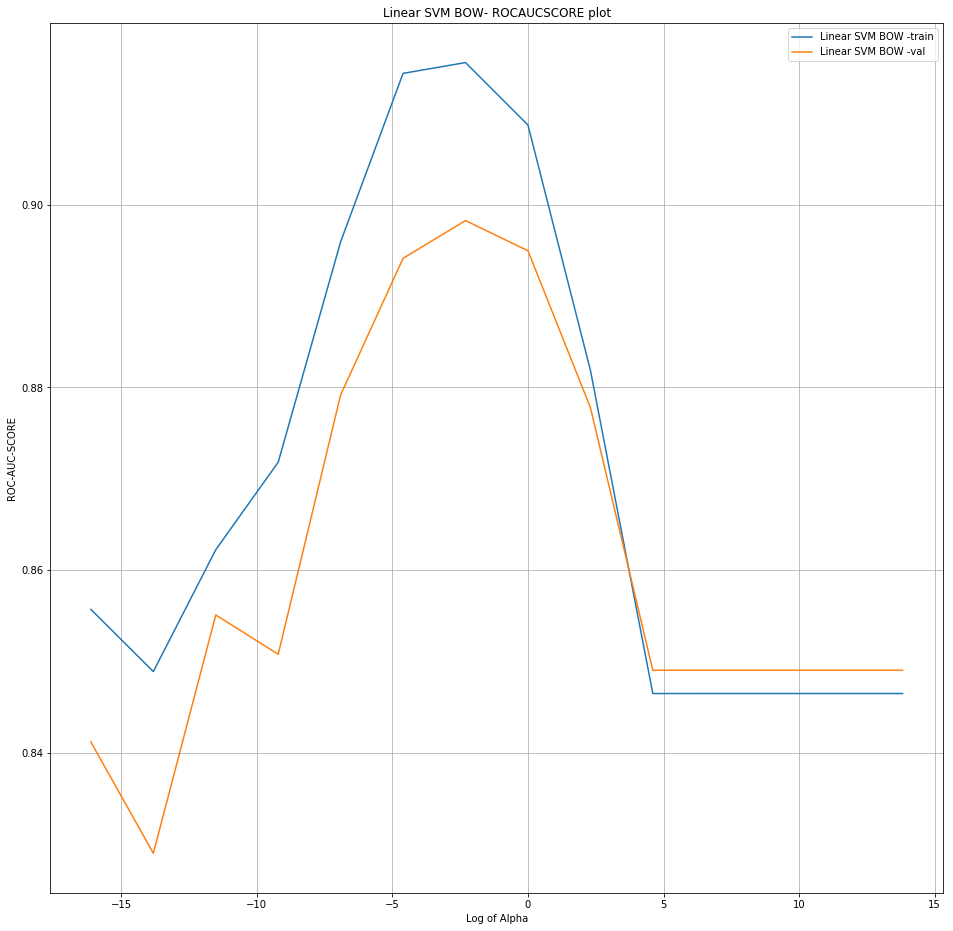

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM BOW- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'Linear SVM BOW -train'
displaygraph.legnd_2 = 'Linear SVM BOW -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = lnrsvm.SVM_alpha
displaygraph.ydatatrn = lnrsvm.rocaucscoretrn
displaygraph.ydataval = lnrsvm.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
# using alpha value returned by gridearchcv
lnrsvm.SVM_actualClasifier(0.001)

-- Epoch 1
Norm: 250.34, NNZs: 500, Bias: -11.768142, T: 23945, Avg. loss: 272.252519
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 137.61, NNZs: 500, Bias: -12.401852, T: 47890, Avg. loss: 55.731028
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 94.24, NNZs: 500, Bias: -12.686839, T: 71835, Avg. loss: 31.892876
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 68.60, NNZs: 500, Bias: -12.881386, T: 95780, Avg. loss: 21.766602
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 58.00, NNZs: 500, Bias: -12.949407, T: 119725, Avg. loss: 18.929339
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 48.04, NNZs: 500, Bias: -12.992264, T: 143670, Avg. loss: 14.598738
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 44.69, NNZs: 500, Bias: -12.983052, T: 167615, Avg. loss: 13.211349
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 37.70, NNZs: 500, Bias: -12.971638, T: 191560, Avg. loss: 11.751479
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 33.86, NNZs: 500, Bias: 

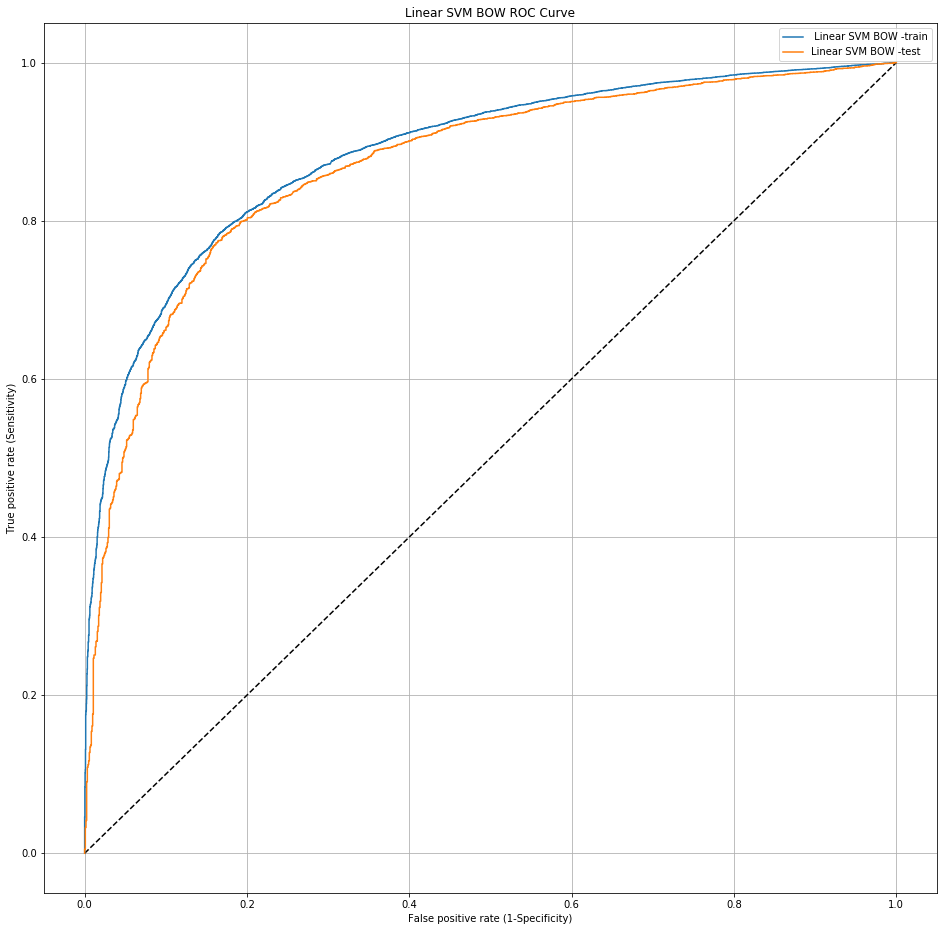

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM BOW ROC Curve'
displaygraph.legnd_1 = ' Linear SVM BOW -train'
displaygraph.legnd_2 = 'Linear SVM BOW -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(lnrsvm.roc_curve_test['fpr_trn'],lnrsvm.roc_curve_test['tpr_trn'],\
                            lnrsvm.roc_curve_test['fpr'],lnrsvm.roc_curve_test['tpr'])

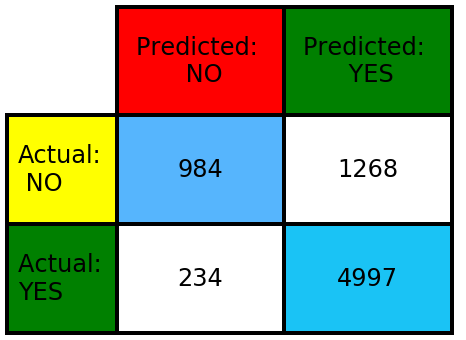

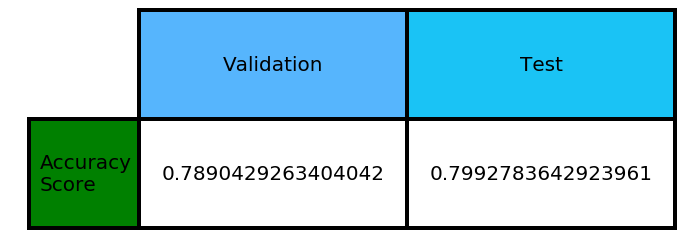

In [0]:
data = [[lnrsvm.confsnmtxytstpred['tn'] ,lnrsvm.confsnmtxytstpred['fn']],[lnrsvm.confsnmtxytstpred['fp'],lnrsvm.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[lnrsvm.accuracy_score_val,lnrsvm.accuracy_score_test]]
#data1=[[0,1]]
displaygraph.draw_accscore(data1)

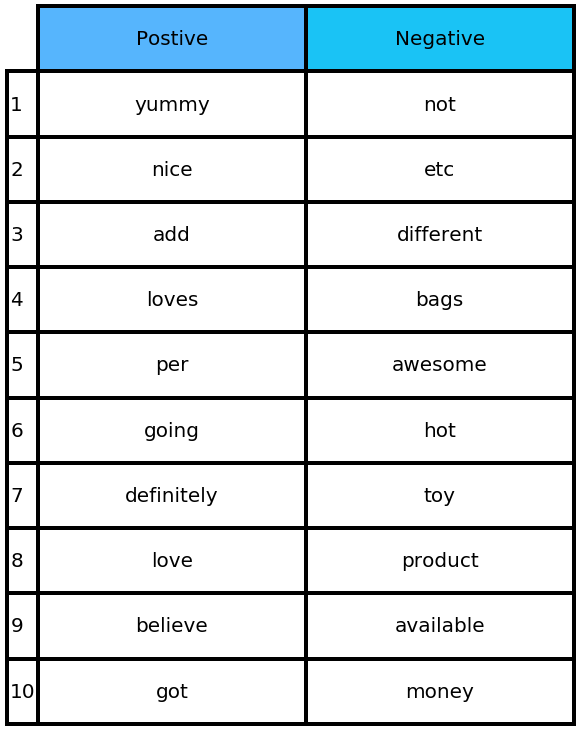

In [0]:
lnrsm_sgdclf = lnrsvm.getSGDClassifier()
feature_names = lnrsvm.feat_names
top10_negve = sorted(zip(lnrsm_sgdclf.coef_[0], feature_names))[-10:]
top10_posve = sorted(zip(lnrsm_sgdclf.coef_[0], feature_names))[:10]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features)

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.44,0.81,0.57], 
         [1,0.96,0.80,0.87]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.44      │ 0.81   │ 0.57      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.96      │ 0.8    │ 0.87      │
╘═══════╧═══════════╧════════╧═══════════╛


In [0]:
#using alpha  value not returned by gridsearhCV
lnrsvm.SVM_actualClasifier(0.1)

-- Epoch 1
Norm: 3.18, NNZs: 500, Bias: -0.660020, T: 23945, Avg. loss: 4.008275
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.17, NNZs: 500, Bias: -0.668609, T: 47890, Avg. loss: 1.352076
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.79, NNZs: 500, Bias: -0.673412, T: 71835, Avg. loss: 1.103648
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1.64, NNZs: 500, Bias: -0.676958, T: 95780, Avg. loss: 1.022349
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1.57, NNZs: 500, Bias: -0.680199, T: 119725, Avg. loss: 1.005098
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 1.52, NNZs: 500, Bias: -0.682808, T: 143670, Avg. loss: 0.993412
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 1.49, NNZs: 500, Bias: -0.684829, T: 167615, Avg. loss: 0.972058
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 1.46, NNZs: 500, Bias: -0.686606, T: 191560, Avg. loss: 0.968923
Total training time: 0.08 seconds.
-- Epoch 9
Norm: 1.42, NNZs: 500, Bias: -0.688432, T: 215505, Avg. l

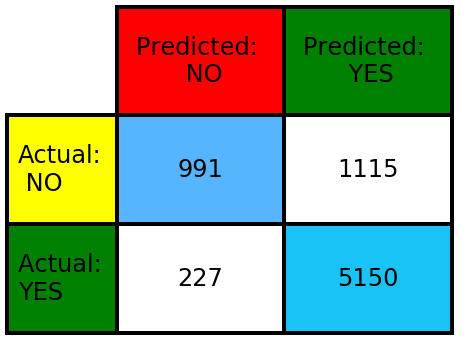

In [0]:
data = [[lnrsvm.confsnmtxytstpred['tn'] ,lnrsvm.confsnmtxytstpred['fn']],[lnrsvm.confsnmtxytstpred['fp'],lnrsvm.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

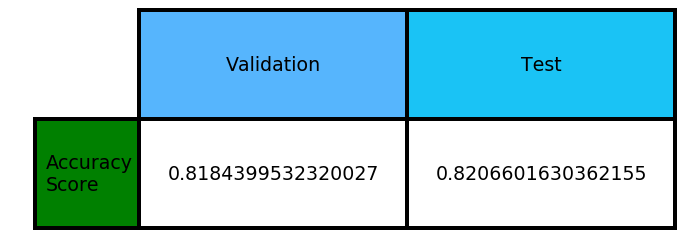

In [0]:
data1= [[lnrsvm.accuracy_score_val,lnrsvm.accuracy_score_test]]
#data1=[[0,1]]
displaygraph.draw_accscore(data1)

#### Precision, Recall and f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.47,0.81,0.60], 
         [1,0.96,0.82,0.88]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.47      │ 0.81   │ 0.6       │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.96      │ 0.82   │ 0.88      │
╘═══════╧═══════════╧════════╧═══════════╛


### Feature Importance  for Linear SVM ###

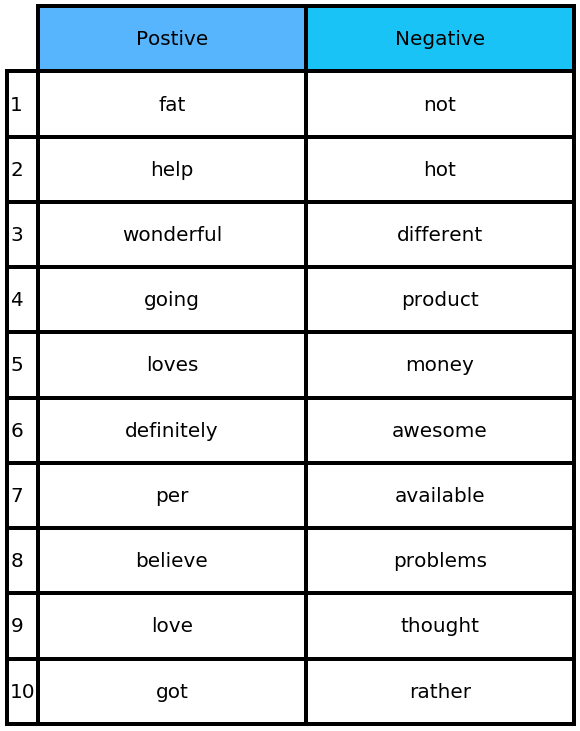

In [0]:
lnrsm_sgdclf = lnrsvm.getSGDClassifier()
feature_names = lnrsvm.feat_names
top10_negve = sorted(zip(lnrsm_sgdclf.coef_[0], feature_names))[-10:]
top10_posve = sorted(zip(lnrsm_sgdclf.coef_[0], feature_names))[:10]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features)

#### Features a visual treat ####

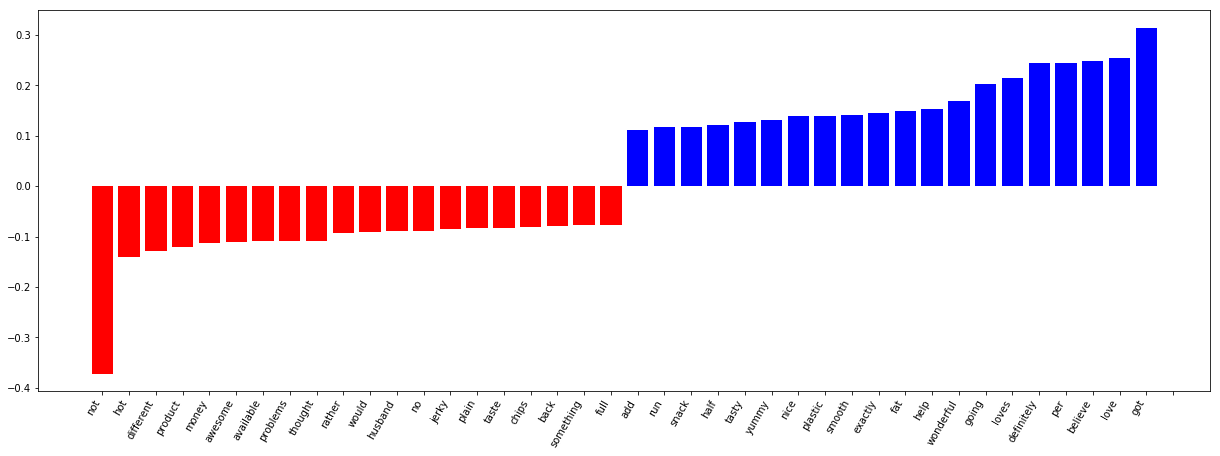

In [0]:
no_feat = 20
coef = lnrsm_sgdclf.coef_.ravel()

top_posve_coef = np.argsort(coef)[-no_feat:]
top_negve_coef = np.argsort(coef)[:no_feat]

top_coefs = np.hstack([top_negve_coef, top_posve_coef])
feature_names = lnrsvm.feat_names

displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.visual_featname(feature_names,coef,top_coefs,no_feat)


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for TFIDF ####

0.9013660913329639
{'alpha': 0.01, 'penalty': 'l2'}
GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2', 'l1'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)



In [0]:
lnrsvm_tidf = assign7SVM()
lnrsm_tidfclf = lnrsvm_tidf.SGDClasifier()
lnrsvm_tidf.load_data('TFIDF')
lnrsvm_tidf.setpenaltyparm('l2')

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)

In [0]:
lnrsvm_tidf.SVM_calcrocaucscore(1000000)

SGDClassifier(alpha=1e-07, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 67908.01, NNZs: 500, Bias: -6686.158584, T: 23945, Avg. loss: 10003.893301
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 62887.96, NNZs: 500, Bias: -9233.542391, T: 47890, Avg. loss: 9053.156150
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 57489.95, NNZs: 500, Bias: -12854.771624, T: 71835, Avg. loss: 8222.640881
Total training time: 0.09 seconds.
-- Epoch 4
Norm: 51869.59, NNZs: 500, Bias: -11411.463884, T: 95780, Avg. loss: 7583.145196
Total training time: 0.12 seconds.
-- Epoch 5
Norm: 49075.13, NNZs: 500, Bias: -11334.090497, T: 119725, Avg. loss: 

Total training time: 3.59 seconds.
-- Epoch 126
Norm: 4470.01, NNZs: 500, Bias: -1120.452701, T: 3017070, Avg. loss: 608.718993
Total training time: 3.62 seconds.
-- Epoch 127
Norm: 4216.47, NNZs: 500, Bias: -1127.686091, T: 3041015, Avg. loss: 604.101512
Total training time: 3.65 seconds.
-- Epoch 128
Norm: 4352.87, NNZs: 500, Bias: -1192.888537, T: 3064960, Avg. loss: 592.566910
Total training time: 3.68 seconds.
-- Epoch 129
Norm: 4356.52, NNZs: 500, Bias: -1043.192395, T: 3088905, Avg. loss: 599.973673
Total training time: 3.70 seconds.
-- Epoch 130
Norm: 4362.70, NNZs: 500, Bias: -934.739447, T: 3112850, Avg. loss: 586.733030
Total training time: 3.73 seconds.
-- Epoch 131
Norm: 4263.29, NNZs: 500, Bias: -882.344273, T: 3136795, Avg. loss: 587.608082
Total training time: 3.76 seconds.
-- Epoch 132
Norm: 4441.70, NNZs: 500, Bias: -863.090563, T: 3160740, Avg. loss: 576.647973
Total training time: 3.79 seconds.
-- Epoch 133
Norm: 4360.72, NNZs: 500, Bias: -826.440931, T: 3184685, Av

Norm: 1180.17, NNZs: 500, Bias: -265.392527, T: 1173305, Avg. loss: 164.332508
Total training time: 1.38 seconds.
-- Epoch 50
Norm: 1144.12, NNZs: 500, Bias: -282.459372, T: 1197250, Avg. loss: 162.104042
Total training time: 1.41 seconds.
-- Epoch 51
Norm: 1176.63, NNZs: 500, Bias: -279.166026, T: 1221195, Avg. loss: 157.376641
Total training time: 1.44 seconds.
-- Epoch 52
Norm: 1120.62, NNZs: 500, Bias: -251.387824, T: 1245140, Avg. loss: 153.454661
Total training time: 1.46 seconds.
-- Epoch 53
Norm: 1094.30, NNZs: 500, Bias: -265.447950, T: 1269085, Avg. loss: 150.584798
Total training time: 1.49 seconds.
-- Epoch 54
Norm: 1088.18, NNZs: 500, Bias: -267.013608, T: 1293030, Avg. loss: 148.067487
Total training time: 1.52 seconds.
-- Epoch 55
Norm: 1038.19, NNZs: 500, Bias: -255.909314, T: 1316975, Avg. loss: 147.626532
Total training time: 1.55 seconds.
-- Epoch 56
Norm: 1067.27, NNZs: 500, Bias: -234.008365, T: 1340920, Avg. loss: 142.432589
Total training time: 1.58 seconds.
-- E

-- Epoch 180
Norm: 332.52, NNZs: 500, Bias: -77.259730, T: 4310100, Avg. loss: 46.290345
Total training time: 5.03 seconds.
-- Epoch 181
Norm: 343.61, NNZs: 500, Bias: -75.945837, T: 4334045, Avg. loss: 44.425926
Total training time: 5.06 seconds.
-- Epoch 182
Norm: 329.07, NNZs: 500, Bias: -69.954425, T: 4357990, Avg. loss: 45.765287
Total training time: 5.09 seconds.
Convergence after 182 epochs took 5.09 seconds
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
SGDClassifier(alpha=9.999999999999999e-06, average=False,
       class_weight={0: 5.14, 1: 1}, early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
  

Norm: 48.63, NNZs: 500, Bias: -12.449944, T: 3017070, Avg. loss: 6.981228
Total training time: 3.65 seconds.
-- Epoch 127
Norm: 46.89, NNZs: 500, Bias: -11.987824, T: 3041015, Avg. loss: 6.900146
Total training time: 3.68 seconds.
-- Epoch 128
Norm: 46.86, NNZs: 500, Bias: -12.752531, T: 3064960, Avg. loss: 6.757660
Total training time: 3.70 seconds.
-- Epoch 129
Norm: 47.41, NNZs: 500, Bias: -11.269935, T: 3088905, Avg. loss: 6.664586
Total training time: 3.73 seconds.
-- Epoch 130
Norm: 48.62, NNZs: 500, Bias: -11.076411, T: 3112850, Avg. loss: 6.546887
Total training time: 3.76 seconds.
-- Epoch 131
Norm: 46.29, NNZs: 500, Bias: -10.436566, T: 3136795, Avg. loss: 6.521259
Total training time: 3.79 seconds.
-- Epoch 132
Norm: 47.59, NNZs: 500, Bias: -10.263943, T: 3160740, Avg. loss: 6.485626
Total training time: 3.82 seconds.
-- Epoch 133
Norm: 47.69, NNZs: 500, Bias: -9.641520, T: 3184685, Avg. loss: 6.506479
Total training time: 3.84 seconds.
-- Epoch 134
Norm: 48.12, NNZs: 500, B

Norm: 9.07, NNZs: 500, Bias: -2.201058, T: 1843765, Avg. loss: 1.438298
Total training time: 2.17 seconds.
-- Epoch 78
Norm: 8.96, NNZs: 500, Bias: -2.297522, T: 1867710, Avg. loss: 1.404135
Total training time: 2.20 seconds.
-- Epoch 79
Norm: 8.91, NNZs: 500, Bias: -2.470628, T: 1891655, Avg. loss: 1.418930
Total training time: 2.23 seconds.
-- Epoch 80
Norm: 9.51, NNZs: 500, Bias: -2.403506, T: 1915600, Avg. loss: 1.411521
Total training time: 2.26 seconds.
-- Epoch 81
Norm: 9.14, NNZs: 500, Bias: -2.290263, T: 1939545, Avg. loss: 1.371630
Total training time: 2.29 seconds.
-- Epoch 82
Norm: 8.81, NNZs: 500, Bias: -2.098975, T: 1963490, Avg. loss: 1.366333
Total training time: 2.32 seconds.
-- Epoch 83
Norm: 9.00, NNZs: 500, Bias: -2.147827, T: 1987435, Avg. loss: 1.371895
Total training time: 2.35 seconds.
-- Epoch 84
Norm: 8.47, NNZs: 500, Bias: -2.245180, T: 2011380, Avg. loss: 1.338994
Total training time: 2.37 seconds.
-- Epoch 85
Norm: 8.55, NNZs: 500, Bias: -2.250805, T: 20353

-- Epoch 12
Norm: 1.97, NNZs: 500, Bias: -0.767827, T: 287340, Avg. loss: 0.469813
Total training time: 0.36 seconds.
-- Epoch 13
Norm: 1.94, NNZs: 500, Bias: -0.740570, T: 311285, Avg. loss: 0.457302
Total training time: 0.39 seconds.
-- Epoch 14
Norm: 1.90, NNZs: 500, Bias: -0.711970, T: 335230, Avg. loss: 0.459215
Total training time: 0.42 seconds.
-- Epoch 15
Norm: 1.88, NNZs: 500, Bias: -0.702518, T: 359175, Avg. loss: 0.451029
Total training time: 0.45 seconds.
-- Epoch 16
Norm: 1.87, NNZs: 500, Bias: -0.681996, T: 383120, Avg. loss: 0.450079
Total training time: 0.48 seconds.
-- Epoch 17
Norm: 1.84, NNZs: 500, Bias: -0.671221, T: 407065, Avg. loss: 0.447881
Total training time: 0.51 seconds.
-- Epoch 18
Norm: 1.82, NNZs: 500, Bias: -0.654161, T: 431010, Avg. loss: 0.444216
Total training time: 0.54 seconds.
-- Epoch 19
Norm: 1.80, NNZs: 500, Bias: -0.645634, T: 454955, Avg. loss: 0.435731
Total training time: 0.57 seconds.
-- Epoch 20
Norm: 1.77, NNZs: 500, Bias: -0.648040, T: 4

Norm: 0.00, NNZs: 500, Bias: 0.031619, T: 47890, Avg. loss: 0.978685
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 0.00, NNZs: 500, Bias: 0.031619, T: 71835, Avg. loss: 0.978685
Total training time: 0.13 seconds.
-- Epoch 4
Norm: 0.00, NNZs: 500, Bias: 0.031619, T: 95780, Avg. loss: 0.978685
Total training time: 0.17 seconds.
-- Epoch 5
Norm: 0.00, NNZs: 500, Bias: 0.031619, T: 119725, Avg. loss: 0.978685
Total training time: 0.21 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 500, Bias: 0.031619, T: 143670, Avg. loss: 0.978685
Total training time: 0.25 seconds.
Convergence after 6 epochs took 0.25 seconds
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Function exiting...


In [0]:
print(lnrsvm_tidf.rocaucscoretrn)
print(lnrsvm_tidf.rocaucscoreval)
print(lnrsvm_tidf.SVM_alpha)

[0.8522283382373208, 0.8575372214219182, 0.8582824285551314, 0.8823186415224694, 0.9077156397190429, 0.9197094839125097, 0.9198184372589194, 0.9129229601257348, 0.884261657784303, 0.8833642663148653, 0.8833642535284147, 0.8833642535284147, 0.8833653659496254, 0.8833653659496254]
[0.8322837568596146, 0.8410622568029475, 0.8425883722037985, 0.8639504974401175, 0.8909857149192614, 0.9008835988482582, 0.9022011129781199, 0.8983869537151558, 0.8768494884341272, 0.8761251328395889, 0.8761253381558004, 0.8761253381558004, 0.8761259541044354, 0.8761259541044354]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


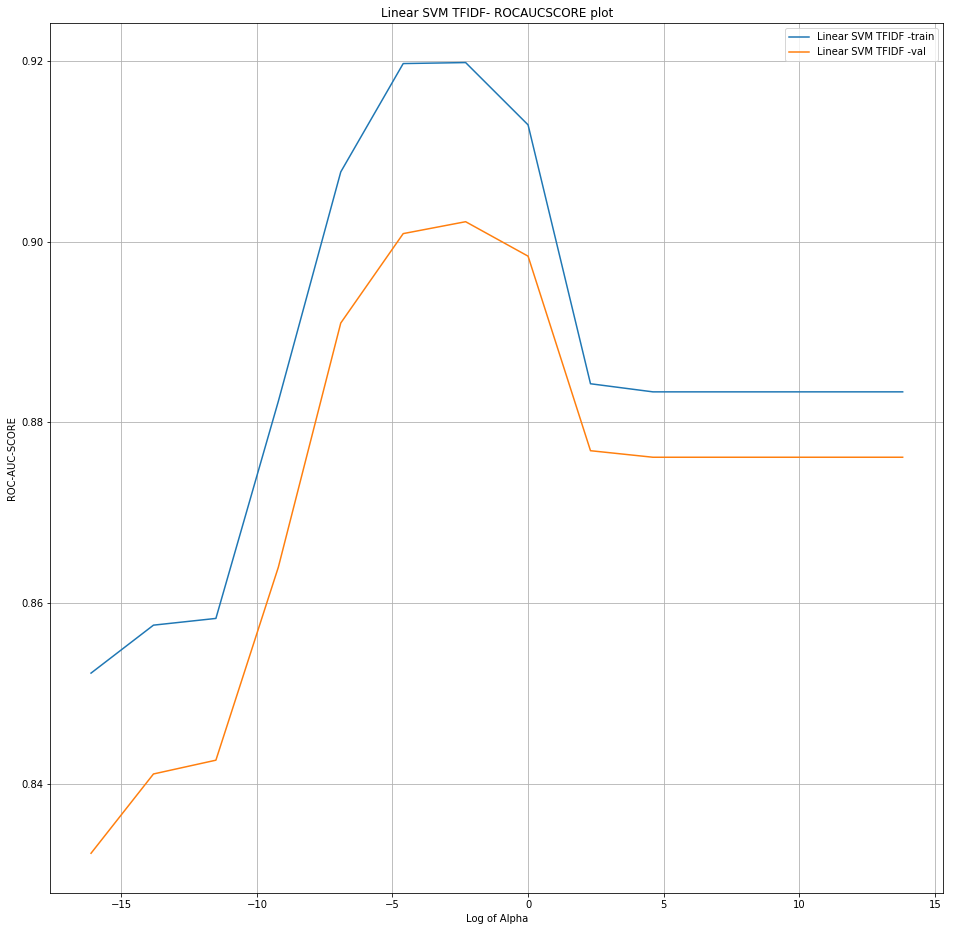

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM TFIDF- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'Linear SVM TFIDF -train'
displaygraph.legnd_2 = 'Linear SVM TFIDF -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = lnrsvm_tidf.SVM_alpha
displaygraph.ydatatrn = lnrsvm_tidf.rocaucscoretrn
displaygraph.ydataval = lnrsvm_tidf.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
lnrsvm_tidf.SVM_actualClasifier(0.01)

-- Epoch 1
Norm: 33.32, NNZs: 500, Bias: -86.744240, T: 23945, Avg. loss: 37.217504
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 26.96, NNZs: 500, Bias: -75.625871, T: 47890, Avg. loss: 10.610571
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 24.72, NNZs: 500, Bias: -68.708731, T: 71835, Avg. loss: 8.656406
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 22.90, NNZs: 500, Bias: -63.958557, T: 95780, Avg. loss: 7.622002
Total training time: 0.13 seconds.
-- Epoch 5
Norm: 22.01, NNZs: 500, Bias: -60.221799, T: 119725, Avg. loss: 7.038346
Total training time: 0.17 seconds.
-- Epoch 6
Norm: 20.62, NNZs: 500, Bias: -57.446239, T: 143670, Avg. loss: 6.530150
Total training time: 0.20 seconds.
-- Epoch 7
Norm: 19.94, NNZs: 500, Bias: -54.971734, T: 167615, Avg. loss: 6.213746
Total training time: 0.23 seconds.
-- Epoch 8
Norm: 19.37, NNZs: 500, Bias: -52.838291, T: 191560, Avg. loss: 5.852129
Total training time: 0.27 seconds.
-- Epoch 9
Norm: 18.82, NNZs: 500, Bias: -50.99680

-- Epoch 137
Norm: 6.54, NNZs: 500, Bias: -14.950816, T: 3280465, Avg. loss: 1.845483
Total training time: 4.32 seconds.
-- Epoch 138
Norm: 6.48, NNZs: 500, Bias: -14.885984, T: 3304410, Avg. loss: 1.828894
Total training time: 4.35 seconds.
-- Epoch 139
Norm: 6.48, NNZs: 500, Bias: -14.794764, T: 3328355, Avg. loss: 1.839483
Total training time: 4.38 seconds.
-- Epoch 140
Norm: 6.44, NNZs: 500, Bias: -14.720617, T: 3352300, Avg. loss: 1.817058
Total training time: 4.41 seconds.
-- Epoch 141
Norm: 6.42, NNZs: 500, Bias: -14.640108, T: 3376245, Avg. loss: 1.816287
Total training time: 4.45 seconds.
-- Epoch 142
Norm: 6.41, NNZs: 500, Bias: -14.556856, T: 3400190, Avg. loss: 1.806668
Total training time: 4.48 seconds.
-- Epoch 143
Norm: 6.35, NNZs: 500, Bias: -14.494493, T: 3424135, Avg. loss: 1.794664
Total training time: 4.51 seconds.
-- Epoch 144
Norm: 6.33, NNZs: 500, Bias: -14.416565, T: 3448080, Avg. loss: 1.790630
Total training time: 4.54 seconds.
-- Epoch 145
Norm: 6.30, NNZs: 5

Total training time: 6.38 seconds.
-- Epoch 205
Norm: 4.94, NNZs: 500, Bias: -10.773185, T: 4908725, Avg. loss: 1.479611
Total training time: 6.41 seconds.
-- Epoch 206
Norm: 4.94, NNZs: 500, Bias: -10.718357, T: 4932670, Avg. loss: 1.479533
Total training time: 6.44 seconds.
-- Epoch 207
Norm: 4.92, NNZs: 500, Bias: -10.670230, T: 4956615, Avg. loss: 1.472622
Total training time: 6.47 seconds.
-- Epoch 208
Norm: 4.90, NNZs: 500, Bias: -10.624204, T: 4980560, Avg. loss: 1.468859
Total training time: 6.50 seconds.
-- Epoch 209
Norm: 4.87, NNZs: 500, Bias: -10.580138, T: 5004505, Avg. loss: 1.462196
Total training time: 6.53 seconds.
-- Epoch 210
Norm: 4.85, NNZs: 500, Bias: -10.533380, T: 5028450, Avg. loss: 1.459120
Total training time: 6.57 seconds.
-- Epoch 211
Norm: 4.84, NNZs: 500, Bias: -10.486856, T: 5052395, Avg. loss: 1.460767
Total training time: 6.60 seconds.
-- Epoch 212
Norm: 4.82, NNZs: 500, Bias: -10.436733, T: 5076340, Avg. loss: 1.455358
Total training time: 6.63 second

Total training time: 10.76 seconds.
-- Epoch 341
Norm: 3.17, NNZs: 500, Bias: -6.141503, T: 8165245, Avg. loss: 1.107540
Total training time: 10.79 seconds.
-- Epoch 342
Norm: 3.15, NNZs: 500, Bias: -6.120257, T: 8189190, Avg. loss: 1.101903
Total training time: 10.82 seconds.
-- Epoch 343
Norm: 3.14, NNZs: 500, Bias: -6.097561, T: 8213135, Avg. loss: 1.101578
Total training time: 10.85 seconds.
-- Epoch 344
Norm: 3.13, NNZs: 500, Bias: -6.073545, T: 8237080, Avg. loss: 1.096889
Total training time: 10.89 seconds.
-- Epoch 345
Norm: 3.13, NNZs: 500, Bias: -6.049314, T: 8261025, Avg. loss: 1.098526
Total training time: 10.92 seconds.
-- Epoch 346
Norm: 3.12, NNZs: 500, Bias: -6.024276, T: 8284970, Avg. loss: 1.098514
Total training time: 10.95 seconds.
-- Epoch 347
Norm: 3.11, NNZs: 500, Bias: -6.004581, T: 8308915, Avg. loss: 1.090357
Total training time: 10.98 seconds.
-- Epoch 348
Norm: 3.10, NNZs: 500, Bias: -5.980337, T: 8332860, Avg. loss: 1.097179
Total training time: 11.01 secon

Norm: 9.35, NNZs: 500, Bias: -22.969091, T: 1077552, Avg. loss: 2.683781
Total training time: 1.37 seconds.
-- Epoch 37
Norm: 9.22, NNZs: 500, Bias: -22.629024, T: 1107484, Avg. loss: 2.664580
Total training time: 1.41 seconds.
-- Epoch 38
Norm: 9.11, NNZs: 500, Bias: -22.294150, T: 1137416, Avg. loss: 2.628710
Total training time: 1.45 seconds.
-- Epoch 39
Norm: 8.97, NNZs: 500, Bias: -21.984898, T: 1167348, Avg. loss: 2.590119
Total training time: 1.48 seconds.
-- Epoch 40
Norm: 8.91, NNZs: 500, Bias: -21.649612, T: 1197280, Avg. loss: 2.575328
Total training time: 1.52 seconds.
-- Epoch 41
Norm: 8.75, NNZs: 500, Bias: -21.364697, T: 1227212, Avg. loss: 2.519404
Total training time: 1.56 seconds.
-- Epoch 42
Norm: 8.68, NNZs: 500, Bias: -21.054968, T: 1257144, Avg. loss: 2.497656
Total training time: 1.60 seconds.
-- Epoch 43
Norm: 8.59, NNZs: 500, Bias: -20.761400, T: 1287076, Avg. loss: 2.469683
Total training time: 1.63 seconds.
-- Epoch 44
Norm: 8.46, NNZs: 500, Bias: -20.493305,

Norm: 3.04, NNZs: 500, Bias: -5.998217, T: 5148304, Avg. loss: 1.127805
Total training time: 6.56 seconds.
-- Epoch 173
Norm: 3.03, NNZs: 500, Bias: -5.946440, T: 5178236, Avg. loss: 1.127677
Total training time: 6.60 seconds.
-- Epoch 174
Norm: 3.01, NNZs: 500, Bias: -5.897209, T: 5208168, Avg. loss: 1.124055
Total training time: 6.63 seconds.
-- Epoch 175
Norm: 2.99, NNZs: 500, Bias: -5.852743, T: 5238100, Avg. loss: 1.121918
Total training time: 6.67 seconds.
-- Epoch 176
Norm: 2.96, NNZs: 500, Bias: -5.810175, T: 5268032, Avg. loss: 1.110026
Total training time: 6.71 seconds.
-- Epoch 177
Norm: 2.95, NNZs: 500, Bias: -5.762946, T: 5297964, Avg. loss: 1.113071
Total training time: 6.75 seconds.
-- Epoch 178
Norm: 2.93, NNZs: 500, Bias: -5.716912, T: 5327896, Avg. loss: 1.103829
Total training time: 6.79 seconds.
-- Epoch 179
Norm: 2.92, NNZs: 500, Bias: -5.665925, T: 5357828, Avg. loss: 1.108895
Total training time: 6.83 seconds.
-- Epoch 180
Norm: 2.90, NNZs: 500, Bias: -5.622689, 

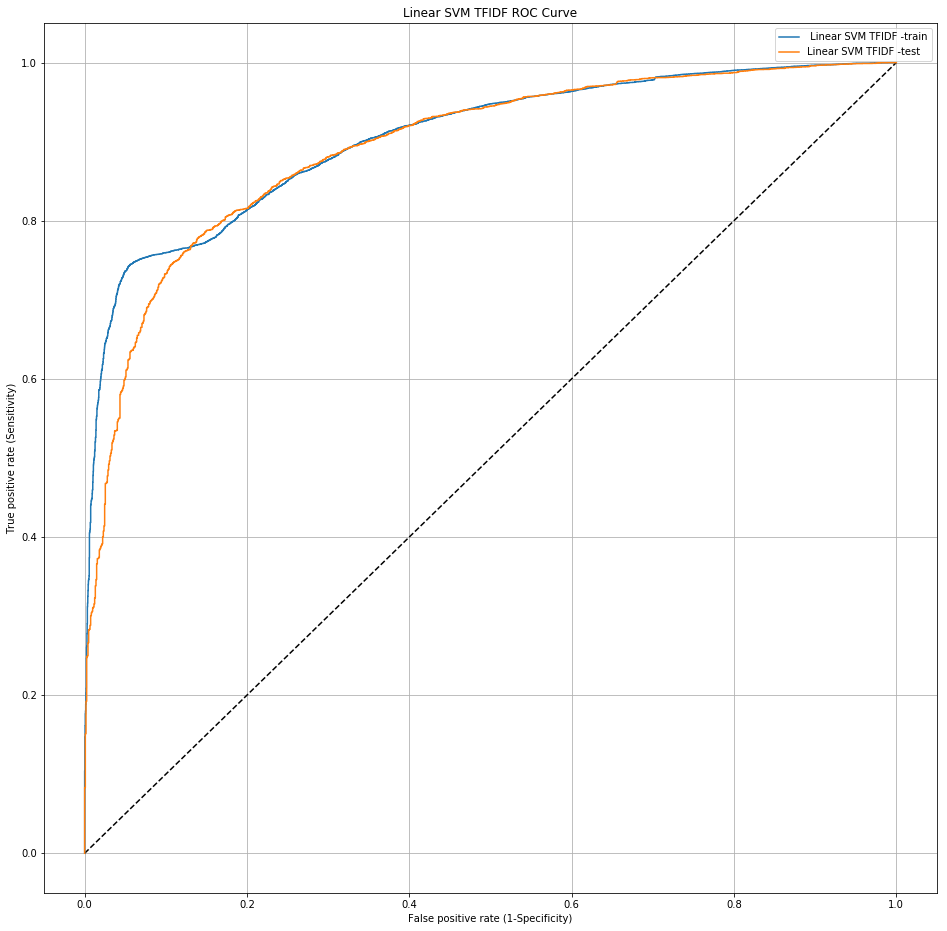

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM TFIDF ROC Curve'
displaygraph.legnd_1 = ' Linear SVM TFIDF -train'
displaygraph.legnd_2 = 'Linear SVM TFIDF -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(lnrsvm_tidf.roc_curve_test['fpr_trn'],lnrsvm_tidf.roc_curve_test['tpr_trn'],\
                            lnrsvm_tidf.roc_curve_test['fpr'],lnrsvm_tidf.roc_curve_test['tpr'])

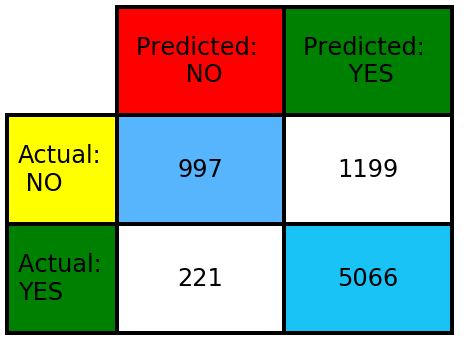

In [0]:
data = [[lnrsvm_tidf.confsnmtxytstpred['tn'] ,lnrsvm_tidf.confsnmtxytstpred['fn']],[lnrsvm_tidf.confsnmtxytstpred['fp'],lnrsvm_tidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

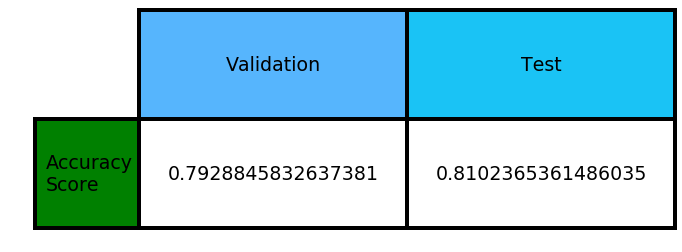

In [0]:
data1= [[lnrsvm_tidf.accuracy_score_val,lnrsvm_tidf.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision,  Recall,  f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.45,0.82,0.58], 
         [1,0.96,0.81,0.88]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.45      │ 0.82   │ 0.58      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.96      │ 0.81   │ 0.88      │
╘═══════╧═══════════╧════════╧═══════════╛


### Feature Importance  for Linear SVM ###

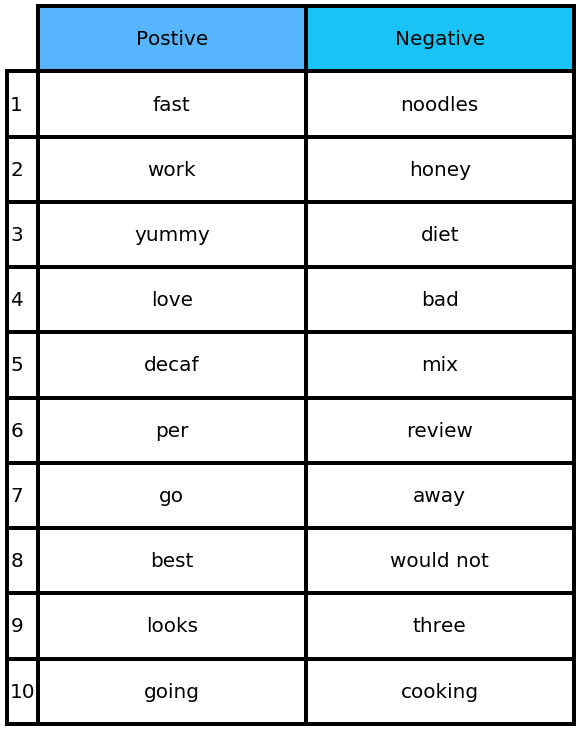

In [0]:
lnrsm_tidfclf = lnrsvm_tidf.getSGDClassifier()
feature_names = lnrsvm_tidf.feat_names
top10_negve = sorted(zip(lnrsm_tidfclf.coef_[0], feature_names))[-10:]
top10_posve = sorted(zip(lnrsm_tidfclf.coef_[0], feature_names))[:10]
feat_pos=[]
feat_neg=[]
features=[]
for coef,feat in (top10_negve):    
    feat_pos.append(feat)
    
for cef,feat in (top10_posve):   
    feat_neg.append(feat)
    
i=0
while i< int(len(feat_pos)):
    feat_item=[]
    feat_item.append(feat_pos[i])
    feat_item.append(feat_neg[i])
    features.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features)

#### FeatureNames - a different prespective ####

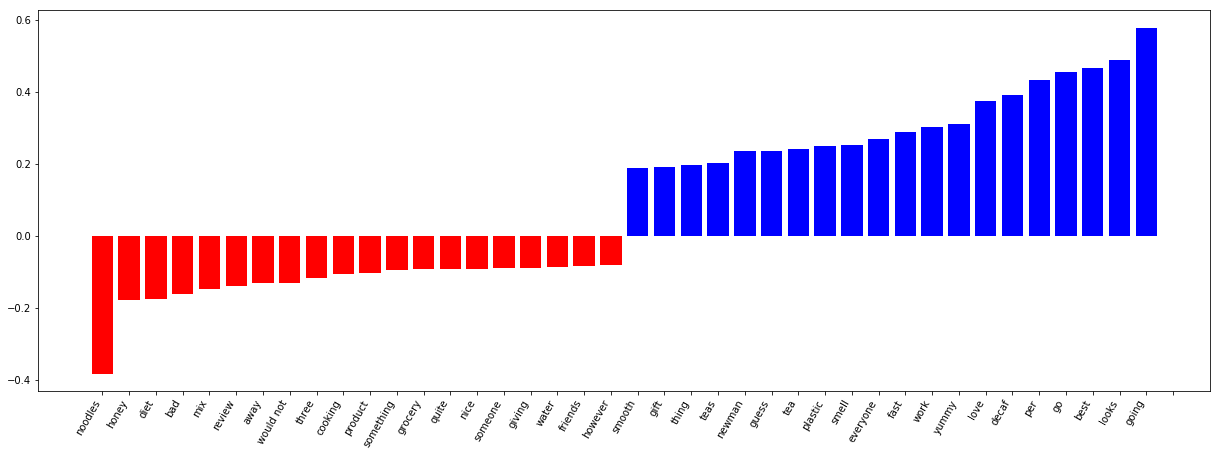

In [0]:
no_feat = 20
coef = lnrsm_tidfclf.coef_.ravel()

top_posve_coef = np.argsort(coef)[-no_feat:]
top_negve_coef = np.argsort(coef)[:no_feat]

top_coefs = np.hstack([top_negve_coef, top_posve_coef])
feature_names = lnrsvm_tidf.feat_names

dspgraph = drawgraphs()
dspgraph.setdefaultparm()
dspgraph.visual_featname(feature_names,coef,top_coefs,no_feat)

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for AVGW2V ####

0.8909825893272035
{'alpha': 0.01, 'penalty': 'l2'}
GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2', 'l1'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
lnrsvmavgw2v = assign7SVM()
lnrsm_sgdclf = lnrsvmavgw2v.SGDClasifier()
lnrsvmavgw2v.load_data('AVGW2V')
lnrsvmavgw2v.setpenaltyparm('l2')

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)

In [0]:
lnrsvmavgw2v.SVM_calcrocaucscore(1000000)

SGDClassifier(alpha=1e-07, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 7481.64, NNZs: 50, Bias: 2717.694835, T: 23945, Avg. loss: 1062.061290
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 6679.53, NNZs: 50, Bias: 2656.980311, T: 47890, Avg. loss: 965.812661
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 6137.71, NNZs: 50, Bias: 2443.776994, T: 71835, Avg. loss: 854.901634
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 5676.97, NNZs: 50, Bias: 2157.489994, T: 95780, Avg. loss: 774.718450
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 5573.67, NNZs: 50, Bias: 2800.608283, T: 119725, Avg. loss: 725.584816
Total train

Total training time: 1.61 seconds.
-- Epoch 131
Norm: 444.97, NNZs: 50, Bias: 287.647536, T: 3136795, Avg. loss: 63.646652
Total training time: 1.62 seconds.
-- Epoch 132
Norm: 485.53, NNZs: 50, Bias: 189.833163, T: 3160740, Avg. loss: 60.236714
Total training time: 1.63 seconds.
-- Epoch 133
Norm: 485.99, NNZs: 50, Bias: 229.306563, T: 3184685, Avg. loss: 59.146965
Total training time: 1.64 seconds.
-- Epoch 134
Norm: 459.69, NNZs: 50, Bias: 169.159667, T: 3208630, Avg. loss: 61.557192
Total training time: 1.65 seconds.
-- Epoch 135
Norm: 434.70, NNZs: 50, Bias: 199.876181, T: 3232575, Avg. loss: 59.932704
Total training time: 1.67 seconds.
-- Epoch 136
Norm: 520.53, NNZs: 50, Bias: 170.793233, T: 3256520, Avg. loss: 61.138931
Total training time: 1.68 seconds.
-- Epoch 137
Norm: 487.28, NNZs: 50, Bias: 179.111576, T: 3280465, Avg. loss: 59.302606
Total training time: 1.69 seconds.
-- Epoch 138
Norm: 509.67, NNZs: 50, Bias: 220.259731, T: 3304410, Avg. loss: 58.940289
Total training t

-- Epoch 83
Norm: 83.79, NNZs: 50, Bias: 39.556843, T: 1987435, Avg. loss: 10.766966
Total training time: 1.00 seconds.
-- Epoch 84
Norm: 88.75, NNZs: 50, Bias: 25.907910, T: 2011380, Avg. loss: 10.044014
Total training time: 1.01 seconds.
-- Epoch 85
Norm: 90.15, NNZs: 50, Bias: 41.325733, T: 2035325, Avg. loss: 10.033877
Total training time: 1.02 seconds.
-- Epoch 86
Norm: 79.42, NNZs: 50, Bias: 34.051217, T: 2059270, Avg. loss: 9.910320
Total training time: 1.03 seconds.
-- Epoch 87
Norm: 87.84, NNZs: 50, Bias: 25.190076, T: 2083215, Avg. loss: 10.162240
Total training time: 1.04 seconds.
-- Epoch 88
Norm: 83.17, NNZs: 50, Bias: 22.664141, T: 2107160, Avg. loss: 9.944817
Total training time: 1.05 seconds.
-- Epoch 89
Norm: 78.32, NNZs: 50, Bias: 35.503999, T: 2131105, Avg. loss: 9.912454
Total training time: 1.06 seconds.
-- Epoch 90
Norm: 77.86, NNZs: 50, Bias: 31.788130, T: 2155050, Avg. loss: 9.431506
Total training time: 1.07 seconds.
-- Epoch 91
Norm: 71.55, NNZs: 50, Bias: 32.

Total training time: 0.70 seconds.
-- Epoch 57
Norm: 12.98, NNZs: 50, Bias: 6.298658, T: 1364865, Avg. loss: 1.957632
Total training time: 0.72 seconds.
-- Epoch 58
Norm: 14.51, NNZs: 50, Bias: 5.398023, T: 1388810, Avg. loss: 1.955066
Total training time: 0.73 seconds.
-- Epoch 59
Norm: 14.22, NNZs: 50, Bias: 6.556500, T: 1412755, Avg. loss: 1.930997
Total training time: 0.74 seconds.
-- Epoch 60
Norm: 11.38, NNZs: 50, Bias: 6.439749, T: 1436700, Avg. loss: 1.859595
Total training time: 0.75 seconds.
-- Epoch 61
Norm: 14.11, NNZs: 50, Bias: 6.636253, T: 1460645, Avg. loss: 1.848903
Total training time: 0.77 seconds.
-- Epoch 62
Norm: 13.84, NNZs: 50, Bias: 5.194281, T: 1484590, Avg. loss: 1.768412
Total training time: 0.78 seconds.
-- Epoch 63
Norm: 12.40, NNZs: 50, Bias: 5.946917, T: 1508535, Avg. loss: 1.758960
Total training time: 0.80 seconds.
-- Epoch 64
Norm: 13.42, NNZs: 50, Bias: 6.762765, T: 1532480, Avg. loss: 1.776700
Total training time: 0.81 seconds.
-- Epoch 65
Norm: 11.

Norm: 3.84, NNZs: 50, Bias: 1.347364, T: 933855, Avg. loss: 0.684962
Total training time: 0.46 seconds.
-- Epoch 40
Norm: 3.78, NNZs: 50, Bias: 1.818505, T: 957800, Avg. loss: 0.672191
Total training time: 0.47 seconds.
-- Epoch 41
Norm: 3.94, NNZs: 50, Bias: 1.398279, T: 981745, Avg. loss: 0.667341
Total training time: 0.49 seconds.
-- Epoch 42
Norm: 3.65, NNZs: 50, Bias: 1.744330, T: 1005690, Avg. loss: 0.654538
Total training time: 0.50 seconds.
-- Epoch 43
Norm: 3.67, NNZs: 50, Bias: 1.459958, T: 1029635, Avg. loss: 0.659436
Total training time: 0.51 seconds.
-- Epoch 44
Norm: 3.52, NNZs: 50, Bias: 1.527687, T: 1053580, Avg. loss: 0.647871
Total training time: 0.52 seconds.
-- Epoch 45
Norm: 3.70, NNZs: 50, Bias: 1.511633, T: 1077525, Avg. loss: 0.658361
Total training time: 0.53 seconds.
-- Epoch 46
Norm: 3.59, NNZs: 50, Bias: 1.571177, T: 1101470, Avg. loss: 0.638764
Total training time: 0.54 seconds.
-- Epoch 47
Norm: 3.62, NNZs: 50, Bias: 1.305241, T: 1125415, Avg. loss: 0.6469

Norm: 0.00, NNZs: 50, Bias: 0.173104, T: 119725, Avg. loss: 0.882288
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.00, NNZs: 50, Bias: 0.173104, T: 143670, Avg. loss: 0.882290
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.08 seconds
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
SGDClassifier(alpha=10000.0, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 0.00, NNZs: 50, Bias: 0.099527, T: 23945, Avg. loss: 0.932775
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.00, NNZ

In [0]:
print(lnrsvmavgw2v.rocaucscoretrn)
print(lnrsvmavgw2v.rocaucscoreval)
print(lnrsvmavgw2v.SVM_alpha)

[0.8473404041894244, 0.7909553787905464, 0.8455799528706771, 0.8328250591315806, 0.8748388683448985, 0.8852253917531945, 0.883861934155763, 0.8769844987045152, 0.8528486025675245, 0.8519250628064066, 0.8519250628064066, 0.8519250628064066, 0.8519271981436733, 0.8519271981436733]
[0.5018410704694515, 0.5388723130267387, 0.5525720372460032, 0.5888622935956125, 0.5622746654577647, 0.6183888179863571, 0.6559267809538827, 0.6535833017146367, 0.6011568336626606, 0.5998777136643688, 0.5998777136643688, 0.5998777136643688, 0.5998775083481571, 0.5998775083481571]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


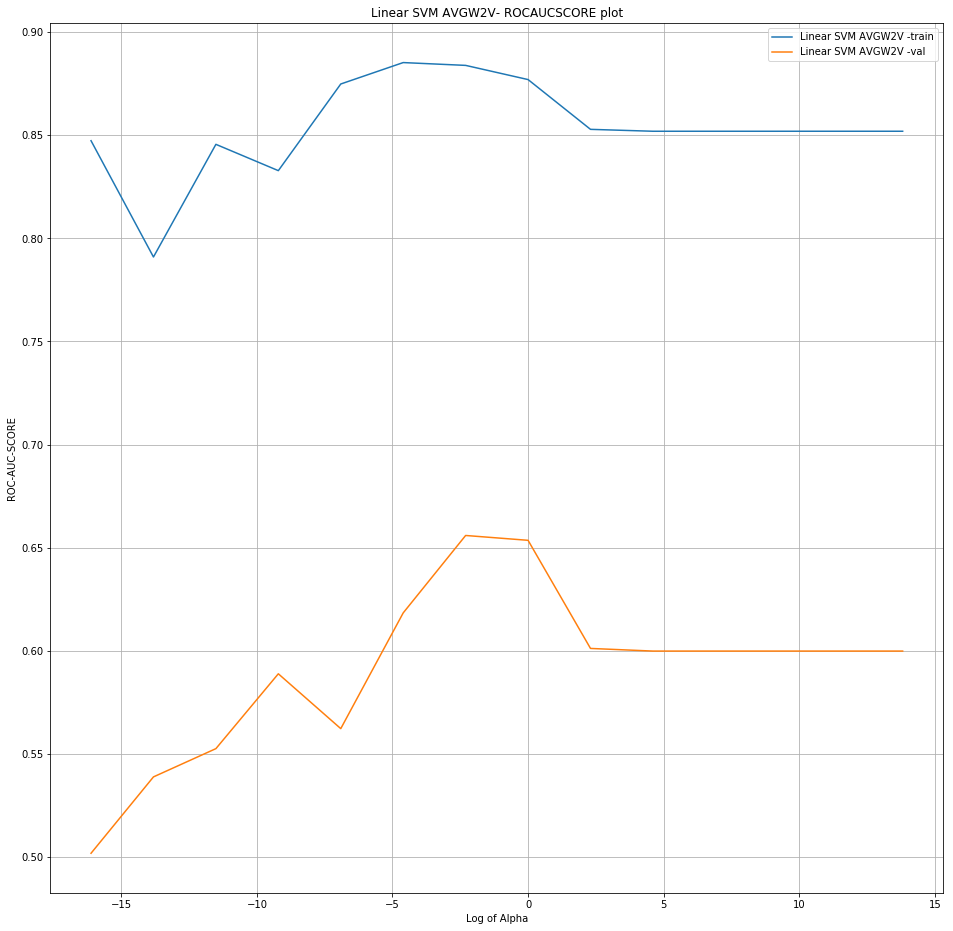

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM AVGW2V- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'Linear SVM AVGW2V -train'
displaygraph.legnd_2 = 'Linear SVM AVGW2V -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = lnrsvmavgw2v.SVM_alpha
displaygraph.ydatatrn = lnrsvmavgw2v.rocaucscoretrn
displaygraph.ydataval = lnrsvmavgw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
#Using alpha returned by gridsearchCV
lnrsvmavgw2v.SVM_actualClasifier(0.01)

-- Epoch 1
Norm: 3.54, NNZs: 50, Bias: -0.516245, T: 23945, Avg. loss: 10.569002
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 2.16, NNZs: 50, Bias: -0.268519, T: 47890, Avg. loss: 1.525838
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1.99, NNZs: 50, Bias: -0.469591, T: 71835, Avg. loss: 1.299442
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.77, NNZs: 50, Bias: -0.551488, T: 95780, Avg. loss: 1.224990
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.67, NNZs: 50, Bias: -0.330999, T: 119725, Avg. loss: 1.182563
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.62, NNZs: 50, Bias: -0.404016, T: 143670, Avg. loss: 1.130369
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 1.62, NNZs: 50, Bias: -0.411684, T: 167615, Avg. loss: 1.139007
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 1.55, NNZs: 50, Bias: -0.380394, T: 191560, Avg. loss: 1.120914
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 1.52, NNZs: 50, Bias: -0.334772, T: 215505, Avg. loss: 1.1

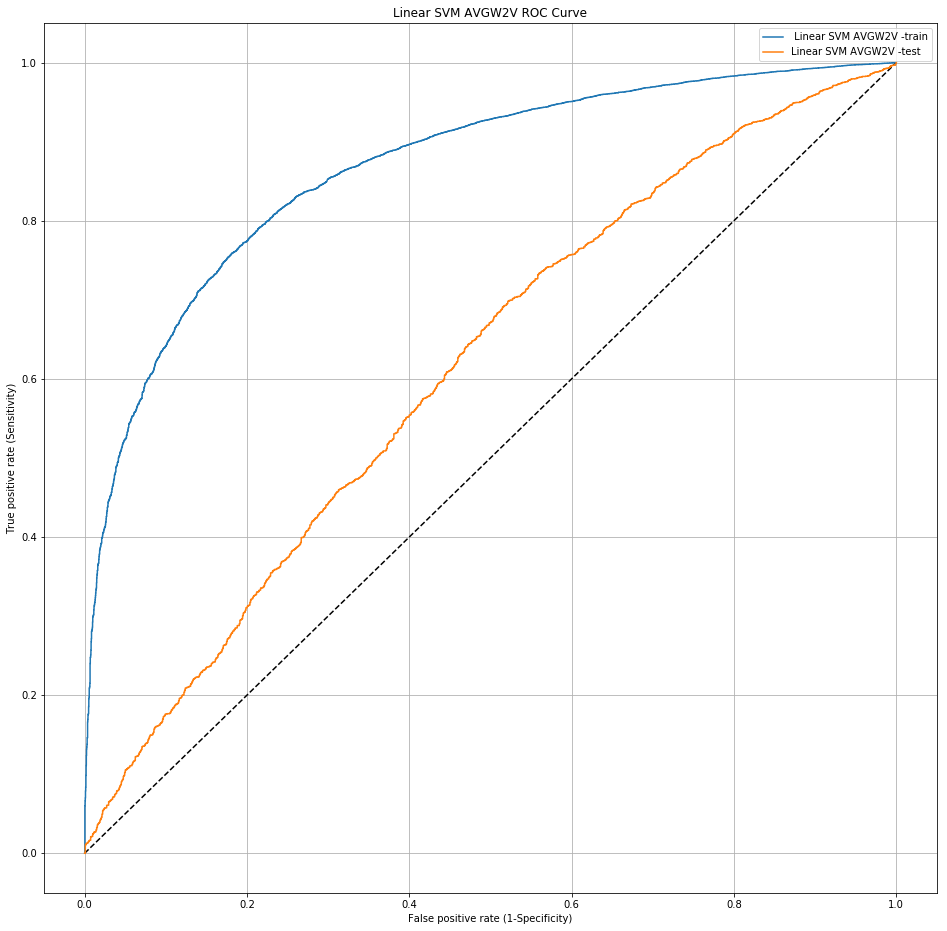

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM AVGW2V ROC Curve'
displaygraph.legnd_1 = ' Linear SVM AVGW2V -train'
displaygraph.legnd_2 = 'Linear SVM AVGW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(lnrsvmavgw2v.roc_curve_test['fpr_trn'],lnrsvmavgw2v.roc_curve_test['tpr_trn'],\
                            lnrsvmavgw2v.roc_curve_test['fpr'],lnrsvmavgw2v.roc_curve_test['tpr'])

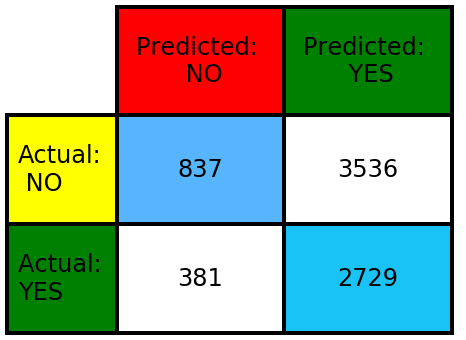

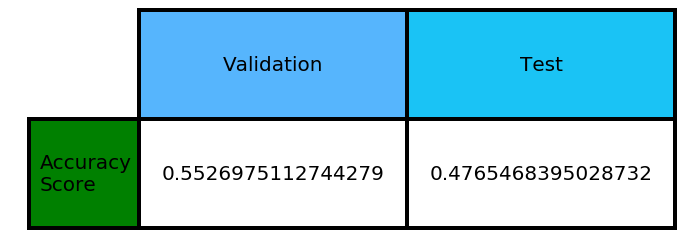

In [0]:
data = [[lnrsvmavgw2v.confsnmtxytstpred['tn'] ,lnrsvmavgw2v.confsnmtxytstpred['fn']],[lnrsvmavgw2v.confsnmtxytstpred['fp'],lnrsvmavgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)
data1= [[lnrsvmavgw2v.accuracy_score_val,lnrsvmavgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision, Recall, f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.21,0.61,0.31 ], 
         [1,0.88,0.55,0.67]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.21      │ 0.61   │ 0.31      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.88      │ 0.55   │ 0.67      │
╘═══════╧═══════════╧════════╧═══════════╛


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for TFIDF W2V####

0.5
{'alpha': 0.0001, 'penalty': 'l2'}
GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2', 'l1'], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
lnrsvmtidfwtw2v = assign7SVM()
lnrsm_sgdclf = lnrsvmtidfwtw2v.SGDClasifier()
lnrsvmtidfwtw2v.load_data('WTW2V')
lnrsvmtidfwtw2v.setpenaltyparm('l2')

SGDClassifier(alpha=0.0001, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)

In [0]:
lnrsvmtidfwtw2v.SVM_calcrocaucscore(1000000)

SGDClassifier(alpha=1e-07, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, warm_start=False)
-- Epoch 1
Norm: 6354.44, NNZs: 50, Bias: 81.369587, T: 23945, Avg. loss: 2134.681716
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 5652.11, NNZs: 50, Bias: -746.501325, T: 47890, Avg. loss: 1866.229852
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 4821.36, NNZs: 50, Bias: 630.549480, T: 71835, Avg. loss: 1687.779596
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 4054.67, NNZs: 50, Bias: 65.574890, T: 95780, Avg. loss: 1563.132261
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 3649.82, NNZs: 50, Bias: -547.150912, T: 119725, Avg. loss: 1422.064972
Total traini

Total training time: 0.16 seconds.
-- Epoch 13
Norm: 365.04, NNZs: 50, Bias: -70.797934, T: 311285, Avg. loss: 129.286602
Total training time: 0.17 seconds.
-- Epoch 14
Norm: 267.23, NNZs: 50, Bias: 7.514753, T: 335230, Avg. loss: 118.672434
Total training time: 0.19 seconds.
-- Epoch 15
Norm: 217.35, NNZs: 50, Bias: -51.783639, T: 359175, Avg. loss: 108.385020
Total training time: 0.21 seconds.
-- Epoch 16
Norm: 252.85, NNZs: 50, Bias: -19.065681, T: 383120, Avg. loss: 101.712238
Total training time: 0.22 seconds.
-- Epoch 17
Norm: 222.13, NNZs: 50, Bias: 14.547769, T: 407065, Avg. loss: 98.042916
Total training time: 0.23 seconds.
-- Epoch 18
Norm: 177.47, NNZs: 50, Bias: 8.534506, T: 431010, Avg. loss: 93.194951
Total training time: 0.25 seconds.
-- Epoch 19
Norm: 220.41, NNZs: 50, Bias: -8.491681, T: 454955, Avg. loss: 87.917144
Total training time: 0.26 seconds.
-- Epoch 20
Norm: 199.42, NNZs: 50, Bias: 34.534974, T: 478900, Avg. loss: 84.848834
Total training time: 0.27 seconds.


Norm: 20.00, NNZs: 50, Bias: -0.861943, T: 502845, Avg. loss: 9.108971
Total training time: 0.28 seconds.
-- Epoch 22
Norm: 26.21, NNZs: 50, Bias: -3.994687, T: 526790, Avg. loss: 8.502643
Total training time: 0.29 seconds.
-- Epoch 23
Norm: 20.55, NNZs: 50, Bias: -3.769021, T: 550735, Avg. loss: 8.438190
Total training time: 0.30 seconds.
-- Epoch 24
Norm: 17.49, NNZs: 50, Bias: 1.905248, T: 574680, Avg. loss: 8.042157
Total training time: 0.31 seconds.
-- Epoch 25
Norm: 22.63, NNZs: 50, Bias: -0.258206, T: 598625, Avg. loss: 7.724845
Total training time: 0.33 seconds.
-- Epoch 26
Norm: 15.65, NNZs: 50, Bias: 0.505237, T: 622570, Avg. loss: 7.409790
Total training time: 0.34 seconds.
-- Epoch 27
Norm: 14.52, NNZs: 50, Bias: 0.602161, T: 646515, Avg. loss: 7.217919
Total training time: 0.35 seconds.
-- Epoch 28
Norm: 18.56, NNZs: 50, Bias: -2.163833, T: 670460, Avg. loss: 6.863052
Total training time: 0.36 seconds.
-- Epoch 29
Norm: 12.74, NNZs: 50, Bias: 1.528170, T: 694405, Avg. loss

       verbose=100, warm_start=False)
-- Epoch 1
Norm: 45.89, NNZs: 50, Bias: -0.311155, T: 23945, Avg. loss: 53.142821
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 22.23, NNZs: 50, Bias: -2.467433, T: 47890, Avg. loss: 12.159360
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 14.74, NNZs: 50, Bias: 2.702874, T: 71835, Avg. loss: 7.351867
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 11.16, NNZs: 50, Bias: 1.234201, T: 95780, Avg. loss: 5.419817
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 10.47, NNZs: 50, Bias: -2.203815, T: 119725, Avg. loss: 4.609003
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 8.25, NNZs: 50, Bias: -1.130465, T: 143670, Avg. loss: 3.919132
Total training time: 0.09 seconds.
-- Epoch 7
Norm: 4.86, NNZs: 50, Bias: -0.102371, T: 167615, Avg. loss: 3.429508
Total training time: 0.10 seconds.
-- Epoch 8
Norm: 7.20, NNZs: 50, Bias: -0.367142, T: 191560, Avg. loss: 3.033743
Total training time: 0.12 seconds.
-- Epoch 9
Norm: 4.75, NNZs: 50, 

Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.05, NNZs: 50, Bias: 0.130902, T: 95780, Avg. loss: 0.904196
Total training time: 0.06 seconds.
-- Epoch 5
Norm: 0.05, NNZs: 50, Bias: 0.130876, T: 119725, Avg. loss: 0.904125
Total training time: 0.07 seconds.
-- Epoch 6
Norm: 0.05, NNZs: 50, Bias: 0.130882, T: 143670, Avg. loss: 0.904070
Total training time: 0.08 seconds.
Convergence after 6 epochs took 0.09 seconds
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
SGDClassifier(alpha=100.0, average=False, class_weight={0: 5.14, 1: 1},
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=100, 

In [0]:
print(lnrsvmtidfwtw2v.rocaucscoretrn)
print(lnrsvmtidfwtw2v.rocaucscoreval)
print(lnrsvmtidfwtw2v.SVM_alpha)

[0.541025480506506, 0.5439656864854864, 0.5337152492719842, 0.5505088713290005, 0.5711432363013065, 0.5744150652724014, 0.5772105861684921, 0.5823513147399416, 0.5771850516264455, 0.5772205020610096, 0.5772204956677844, 0.5772204956677842, 0.5772204956677842, 0.5772205851729393]
[0.5242227960125949, 0.506316758566203, 0.5341812482240147, 0.5026697266994844, 0.5059515010257598, 0.5080991085991358, 0.51162397731995, 0.49392130558115166, 0.5427269195833888, 0.5428110992301464, 0.5428110992301464, 0.5428110992301464, 0.5428110992301464, 0.5428114072044637]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


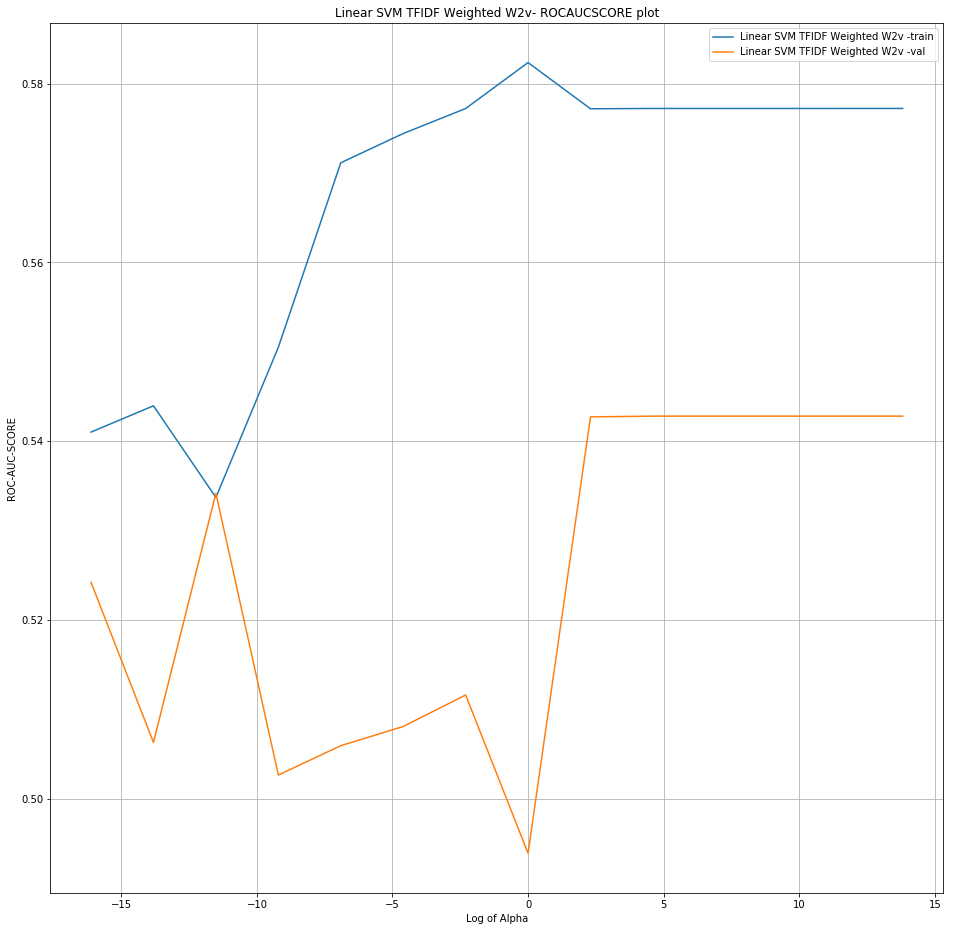

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM TFIDF Weighted W2v- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'Linear SVM TFIDF Weighted W2v -train'
displaygraph.legnd_2 = 'Linear SVM TFIDF Weighted W2v -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of Alpha'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = lnrsvmtidfwtw2v.SVM_alpha
displaygraph.ydatatrn = lnrsvmtidfwtw2v.rocaucscoretrn
displaygraph.ydataval = lnrsvmtidfwtw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
lnrsvmtidfwtw2v.setniterparm(1000)

print((lnrsvmtidfwtw2v.getSGDClassifier))

lnrsvmtidfwtw2v.SVM_actualClasifier(0.0001)


<bound method assign7SVM.getSGDClassifier of <__main__.assign7SVM object at 0x0000000011AB4CF8>>
-- Epoch 1
Norm: 217.72, NNZs: 50, Bias: -188.334189, T: 23945, Avg. loss: 494.034636
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 148.48, NNZs: 50, Bias: -97.784214, T: 47890, Avg. loss: 107.246683
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 81.71, NNZs: 50, Bias: -40.689726, T: 71835, Avg. loss: 60.420862
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 42.11, NNZs: 50, Bias: -19.331255, T: 95780, Avg. loss: 43.061958
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 33.36, NNZs: 50, Bias: -25.170514, T: 119725, Avg. loss: 32.662299
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 39.10, NNZs: 50, Bias: -30.387368, T: 143670, Avg. loss: 28.261639
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 27.70, NNZs: 50, Bias: -27.124701, T: 167615, Avg. loss: 24.444282
Total training time: 0.08 seconds.
-- Epoch 8
Norm: 21.17, NNZs: 50, Bias: -16.004990, T: 191560, Avg. l

Norm: 2.47, NNZs: 50, Bias: -3.047003, T: 2364628, Avg. loss: 3.069351
Total training time: 1.17 seconds.
-- Epoch 80
Norm: 1.44, NNZs: 50, Bias: -2.477238, T: 2394560, Avg. loss: 3.055731
Total training time: 1.19 seconds.
-- Epoch 81
Norm: 2.41, NNZs: 50, Bias: -2.812333, T: 2424492, Avg. loss: 3.025242
Total training time: 1.20 seconds.
-- Epoch 82
Norm: 2.23, NNZs: 50, Bias: -2.556526, T: 2454424, Avg. loss: 3.052033
Total training time: 1.22 seconds.
-- Epoch 83
Norm: 1.99, NNZs: 50, Bias: -2.511781, T: 2484356, Avg. loss: 3.018614
Total training time: 1.23 seconds.
-- Epoch 84
Norm: 1.90, NNZs: 50, Bias: -2.538349, T: 2514288, Avg. loss: 2.978152
Total training time: 1.24 seconds.
-- Epoch 85
Norm: 1.97, NNZs: 50, Bias: -2.643391, T: 2544220, Avg. loss: 2.996936
Total training time: 1.26 seconds.
-- Epoch 86
Norm: 2.38, NNZs: 50, Bias: -2.289157, T: 2574152, Avg. loss: 2.983750
Total training time: 1.27 seconds.
-- Epoch 87
Norm: 2.06, NNZs: 50, Bias: -2.415450, T: 2604084, Avg. 

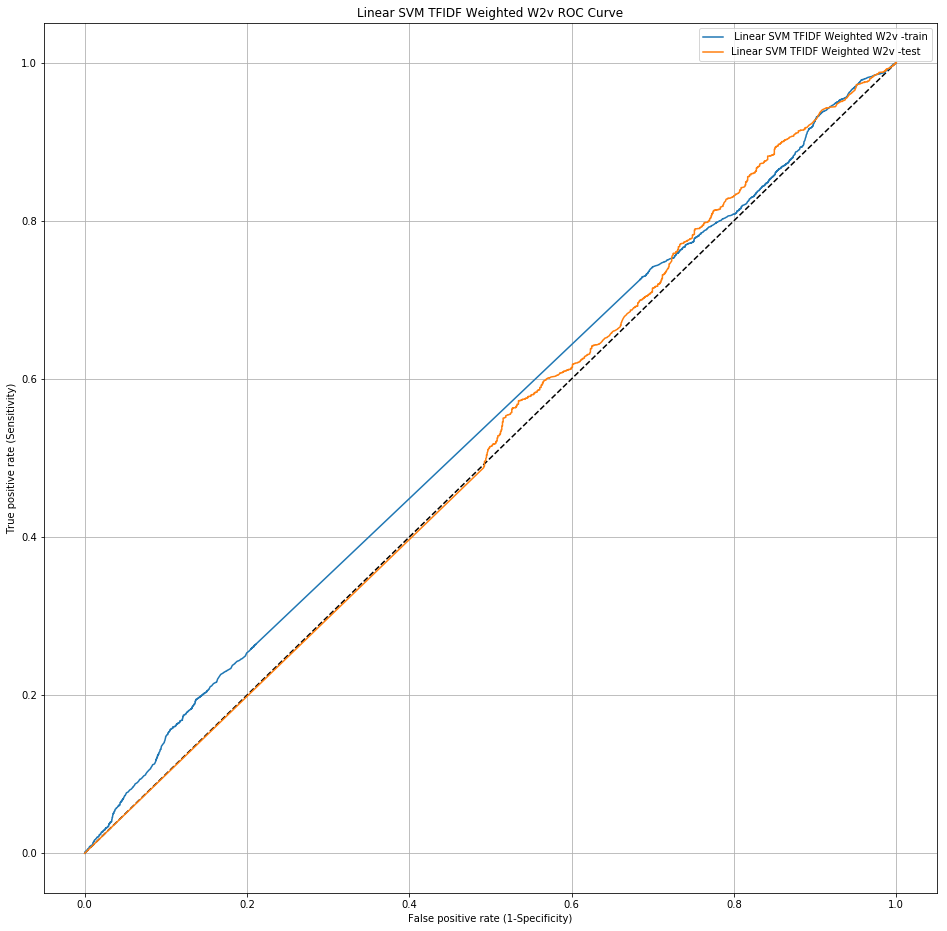

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Linear SVM TFIDF Weighted W2v ROC Curve'
displaygraph.legnd_1 = ' Linear SVM TFIDF Weighted W2v -train'
displaygraph.legnd_2 = 'Linear SVM TFIDF Weighted W2v -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(lnrsvmtidfwtw2v.roc_curve_test['fpr_trn'],lnrsvmtidfwtw2v.roc_curve_test['tpr_trn'],\
                            lnrsvmtidfwtw2v.roc_curve_test['fpr'],lnrsvmtidfwtw2v.roc_curve_test['tpr'])

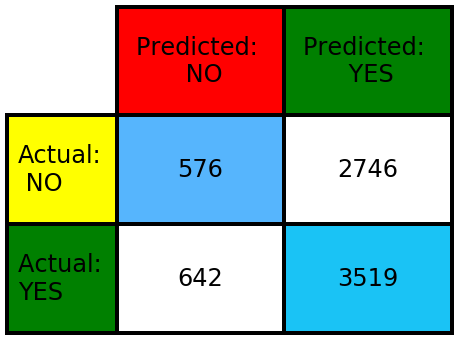

In [0]:
data = [[lnrsvmtidfwtw2v.confsnmtxytstpred['tn'] ,lnrsvmtidfwtw2v.confsnmtxytstpred['fn']],[lnrsvmtidfwtw2v.confsnmtxytstpred['fp'],lnrsvmtidfwtw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

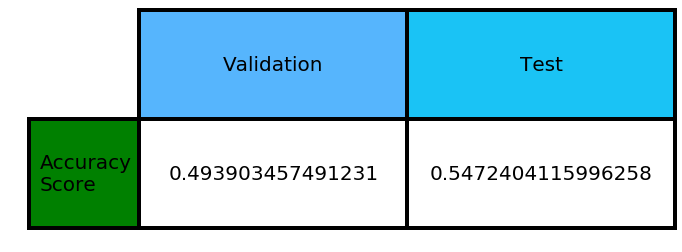

In [0]:
data1= [[lnrsvmtidfwtw2v.accuracy_score_val,lnrsvmtidfwtw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision, Recall, f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.17,0.47,0.25], 
         [1,0.85,0.56,0.64 ]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.17      │ 0.47   │ 0.25      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.85      │ 0.56   │ 0.64      │
╘═══════╧═══════════╧════════╧═══════════╛


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for BOW using RBF kernel####

In [0]:
svmrbfbow = assign7RBF()
svmrbfbow_sgdclf = svmrbfbow.SVMClasifier()
svmrbfbow.load_data('BOW')

In [0]:
svmrbfbow.SVM_calcrocaucscore(1000000)

SVC(C=1e-07, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=1e-06, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=9.999999999999999e-06, cache_size=200, class_weight={0: 5.14, 1: 1},
  coef0=0.0, decision_function_shap

In [0]:
print(svmrbfbow.rocaucscoretrn)
print(svmrbfbow.rocaucscoreval)
print(svmrbfbow.rbf_C)

[0.7006619264225176, 0.7006619839615458, 0.700661932815743, 0.7001861361987667, 0.6922959307401951, 0.6949642008789253, 0.7010135090641743, 0.7195230216592501, 0.7658744808349389, 0.7652572916461284, 0.8141683808821797, 0.7883766649525152, 0.7883766649525152, 0.7883766649525151]
[0.8090971917669842, 0.8090971917669842, 0.8090971917669842, 0.808177375138999, 0.8103956114891666, 0.8104927260572554, 0.8459358477177872, 0.9909921618483059, 0.9996033290791814, 0.9888576945124726, 0.9892863947623014, 0.9892863947623014, 0.9892863947623014, 0.9892863947623014]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


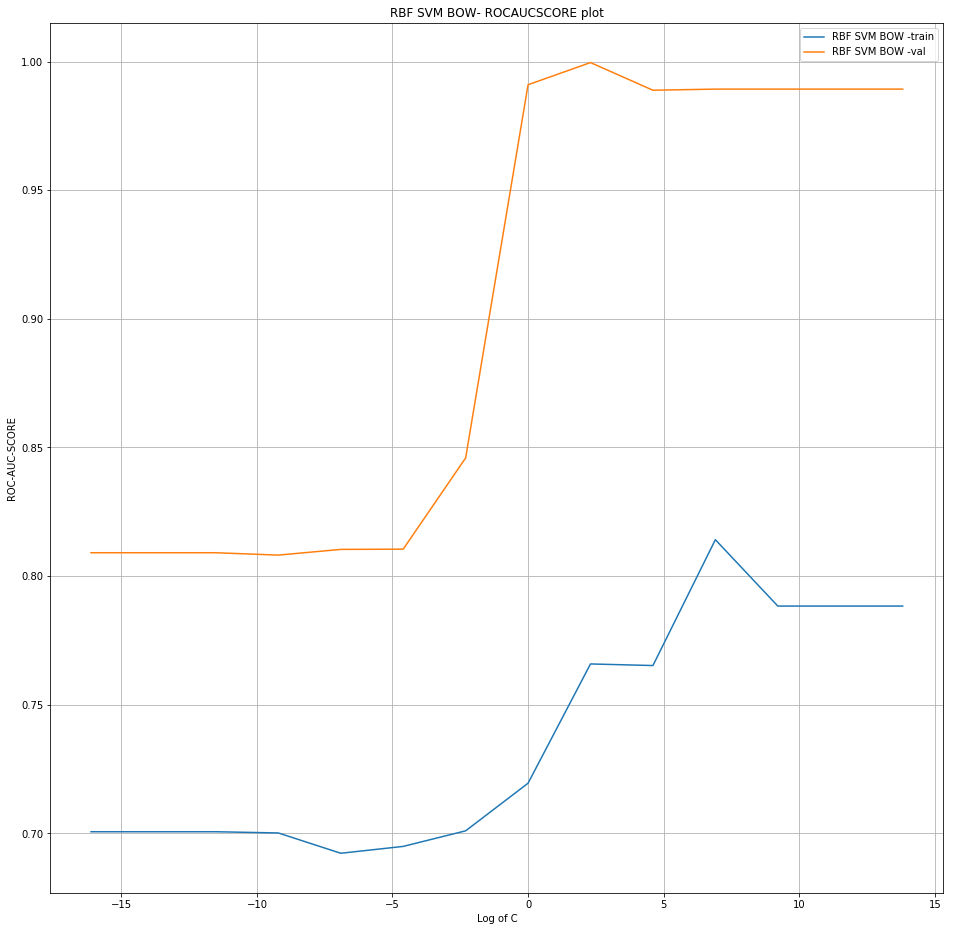

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM BOW- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'RBF SVM BOW -train'
displaygraph.legnd_2 = 'RBF SVM BOW -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = svmrbfbow.rbf_C
displaygraph.ydatatrn = svmrbfbow.rocaucscoretrn
displaygraph.ydataval = svmrbfbow.rocaucscoreval
displaygraph.rocacuscoregraph()

#### Without class and sample weights ####

In [0]:
#has no weights
svmrbfbow.SVM_actualClasifier_0(10)

SVC(C=10, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM][LibSVM][LibSVM]

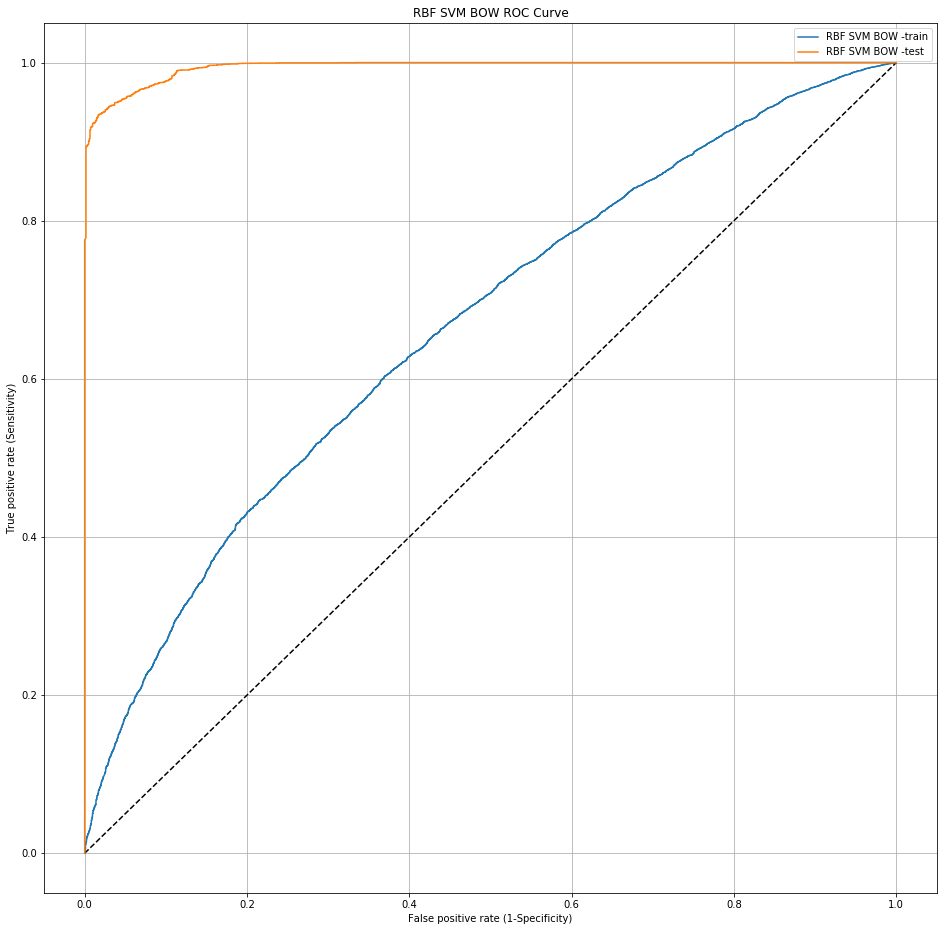

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM BOW ROC Curve'
displaygraph.legnd_1 = 'RBF SVM BOW -train'
displaygraph.legnd_2 = 'RBF SVM BOW -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(svmrbfbow.roc_curve_test['fpr_trn'],svmrbfbow.roc_curve_test['tpr_trn'],\
                            svmrbfbow.roc_curve_test['fpr'],svmrbfbow.roc_curve_test['tpr'])

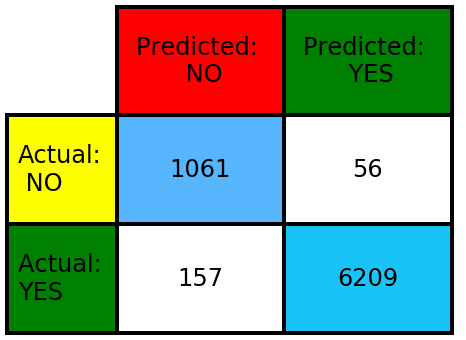

In [0]:
data = [[svmrbfbow.confsnmtxytstpred['tn'] ,svmrbfbow.confsnmtxytstpred['fn']],[svmrbfbow.confsnmtxytstpred['fp'],svmrbfbow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

#### Precision, Recall, f-1 Score  no class or sample weights ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.95,0.87,0.91], 
         [1,0.98,0.99,0.98]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.95      │ 0.87   │ 0.91      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.98      │ 0.99   │ 0.98      │
╘═══════╧═══════════╧════════╧═══════════╛


#### With  sample weights ####

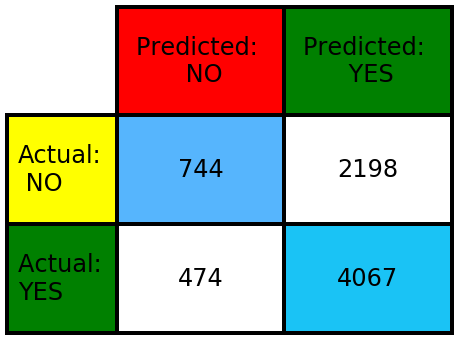

In [0]:
data = [[svmrbfbow.confsnmtxytstpred['tn'] ,svmrbfbow.confsnmtxytstpred['fn']],[svmrbfbow.confsnmtxytstpred['fp'],svmrbfbow.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

#### Precision, Recall, f-1 Score with Class and Sample weights ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.25,0.61,0.36], 
         [1,0.90,0.65,0.75]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.25      │ 0.61   │ 0.36      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.9       │ 0.65   │ 0.75      │
╘═══════╧═══════════╧════════╧═══════════╛


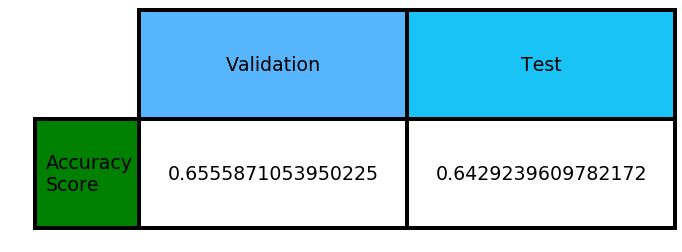

In [0]:
data1= [[svmrbfbow.accuracy_score_val,svmrbfbow.accuracy_score_test]]
displaygraph.draw_accscore(data1)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for TFIDF using RBF kernel####

0.8064366552836055
{'C': 0.1}
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
rbfsvmtfidf = assign7RBF()
rbfsvm_clf = rbfsvmtfidf.SVMClasifier()
rbfsvmtfidf.load_data('TFIDF')

In [0]:
rbfsvmtfidf.SVM_calcrocaucscore(1000000)

SVC(C=1e-07, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=1e-06, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=9.999999999999999e-06, cache_size=200, class_weight={0: 5.14, 1: 1},
  coef0=0.0, decision_function_shap

In [0]:
print(rbfsvmtfidf.rocaucscoretrn)
print(rbfsvmtfidf.rocaucscoreval)
print(rbfsvmtfidf.rbf_C)

[0.8767766613416215, 0.8767766613416215, 0.8767766613416215, 0.874577084946504, 0.8738438331446948, 0.879842340761315, 0.9003607581986786, 0.9124901387695594, 0.91101045233527, 0.9091221109366272, 0.9091221109366272, 0.9091221109366272, 0.9091221109366272, 0.9091221109366272]
[0.941784230729431, 0.941784230729431, 0.941784230729431, 0.9429526852896684, 0.9467383055992193, 0.9588897402667798, 0.9977474758424946, 0.9996248872813999, 0.9988896499276466, 0.9988896499276466, 0.9988896499276466, 0.9988896499276466, 0.9988896499276466, 0.9988896499276466]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


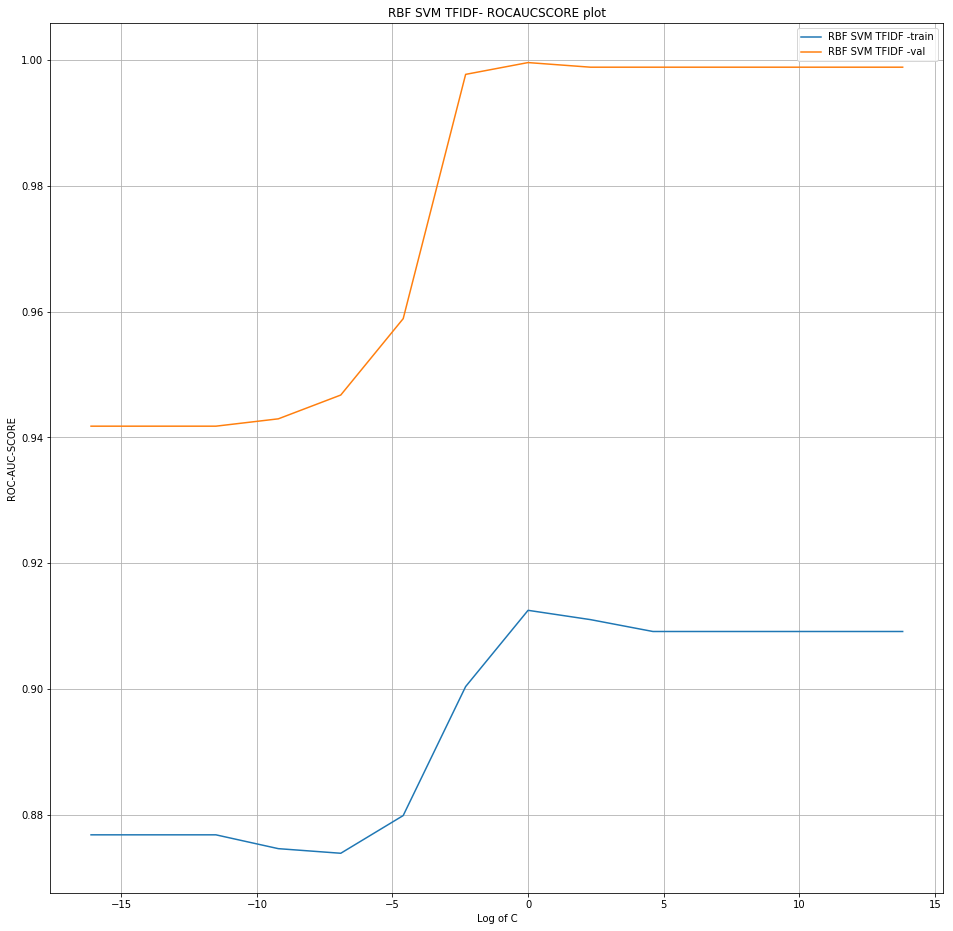

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM TFIDF- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'RBF SVM TFIDF -train'
displaygraph.legnd_2 = 'RBF SVM TFIDF -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = rbfsvmtfidf.rbf_C
displaygraph.ydatatrn = rbfsvmtfidf.rocaucscoretrn
displaygraph.ydataval = rbfsvmtfidf.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
rbfsvmtfidf.SVM_actualClasifier_0(0.1)

SVC(C=0.1, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM][LibSVM][LibSVM]

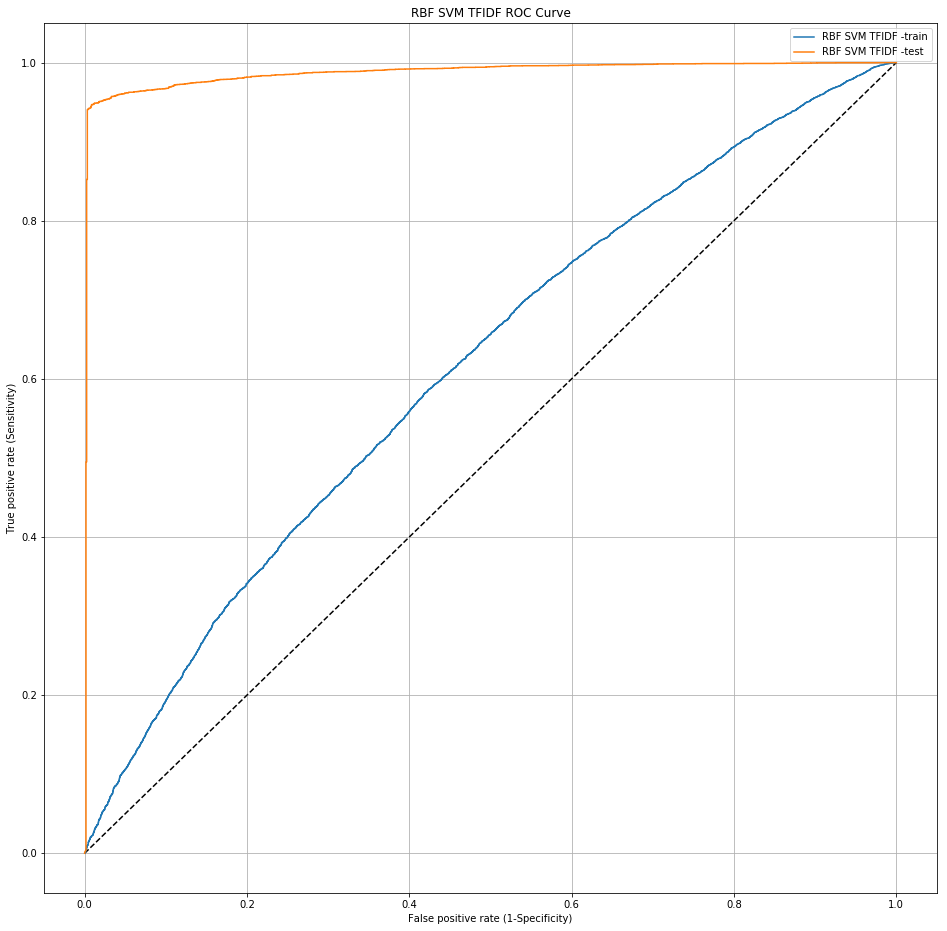

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM TFIDF ROC Curve'
displaygraph.legnd_1 = 'RBF SVM TFIDF -train'
displaygraph.legnd_2 = 'RBF SVM TFIDF -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rbfsvmtfidf.roc_curve_test['fpr_trn'],rbfsvmtfidf.roc_curve_test['tpr_trn'],\
                            rbfsvmtfidf.roc_curve_test['fpr'],rbfsvmtfidf.roc_curve_test['tpr'])

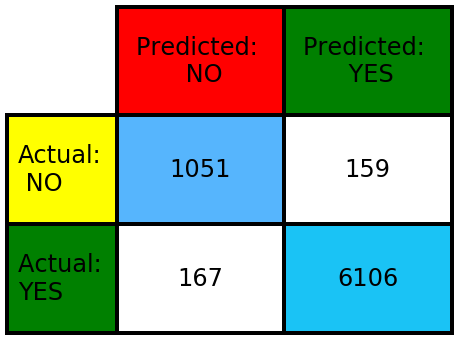

In [0]:
data = [[rbfsvmtfidf.confsnmtxytstpred['tn'] ,rbfsvmtfidf.confsnmtxytstpred['fn']],[rbfsvmtfidf.confsnmtxytstpred['fp'],rbfsvmtfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

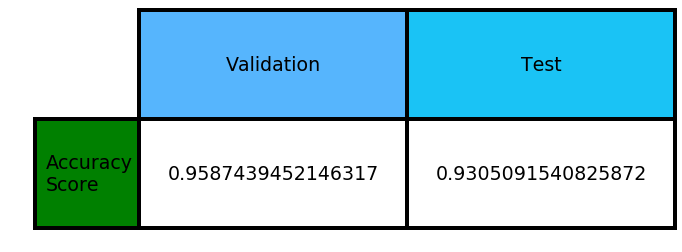

In [0]:
data1= [[rbfsvmtfidf.accuracy_score_val,rbfsvmtfidf.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision, Recall, f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.87,0.86,0.87], 
         [1,0.97,0.97,0.97]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.87      │ 0.86   │ 0.87      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.97      │ 0.97   │ 0.97      │
╘═══════╧═══════════╧════════╧═══════════╛


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for AVGW2V using RBF kernel####

0.6715835848921192
{'C': 0.1}
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
rbfsvmavgw2v = assign7RBF()
rbfsvm_avgw2vclf = rbfsvmavgw2v.SVMClasifier()
rbfsvmavgw2v.load_data('AVGW2V')

In [0]:
rbfsvmavgw2v.SVM_calcrocaucscore(1000000)

SVC(C=1e-07, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=1e-06, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=9.999999999999999e-06, cache_size=200, class_weight={0: 5.14, 1: 1},
  coef0=0.0, decision_function_shap

In [0]:
print(rbfsvmavgw2v.rocaucscoretrn)
print(rbfsvmavgw2v.rocaucscoreval)
print(rbfsvmavgw2v.rbf_C)

[0.689909633805514, 0.689909633805514, 0.689909633805514, 0.689909633805514, 0.6074283959400155, 0.6521907678092307, 0.5765311013918741, 0.6500693549872387, 0.5632229507174644, 0.6736341059443877, 0.6736341059443877, 0.6736341059443877, 0.6736341059443877, 0.6736341059443877]
[0.5387731452965341, 0.4612268547034659, 0.4612268547034659, 0.4612268547034659, 0.4612268547034659, 0.4612268547034659, 0.49896253718276595, 0.49026390524574714, 0.522866066486317, 0.5289159139774349, 0.541208400882367, 0.49607989757184834, 0.49607989757184834, 0.49607989757184834]
[1e-07, 1e-06, 9.999999999999999e-06, 9.999999999999999e-05, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]


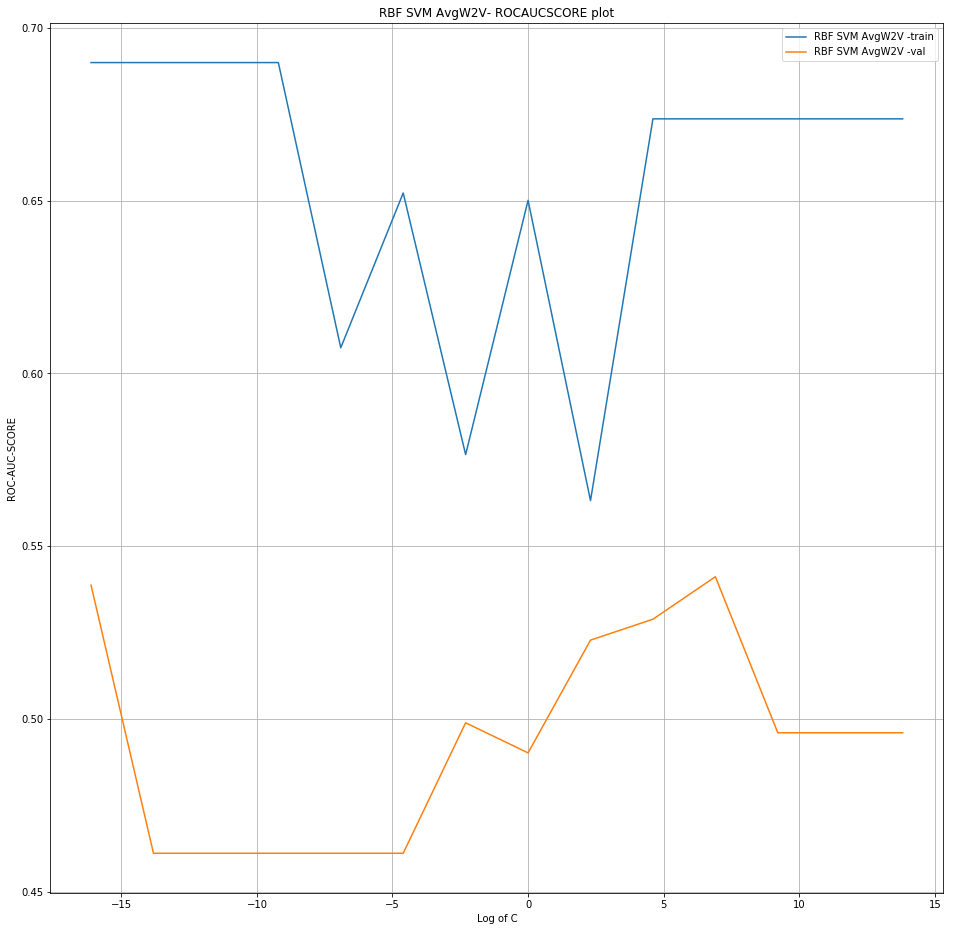

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM AvgW2V- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'RBF SVM AvgW2V -train'
displaygraph.legnd_2 = 'RBF SVM AvgW2V -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = rbfsvmavgw2v.rbf_C
displaygraph.ydatatrn = rbfsvmavgw2v.rocaucscoretrn
displaygraph.ydataval = rbfsvmavgw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
rbfsvmavgw2v.SVM_actualClasifier(0.1)

[LibSVM][LibSVM]***X_test predict [1 1 1 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.18      0.64      0.28      1218
           1       0.86      0.43      0.57      6265

   micro avg       0.47      0.47      0.47      7483
   macro avg       0.52      0.54      0.43      7483
weighted avg       0.75      0.47      0.53      7483

*** predict probabilities*** [0.5261184  0.56073382 0.57145218 ... 0.49277265 0.60571124 0.47123068]


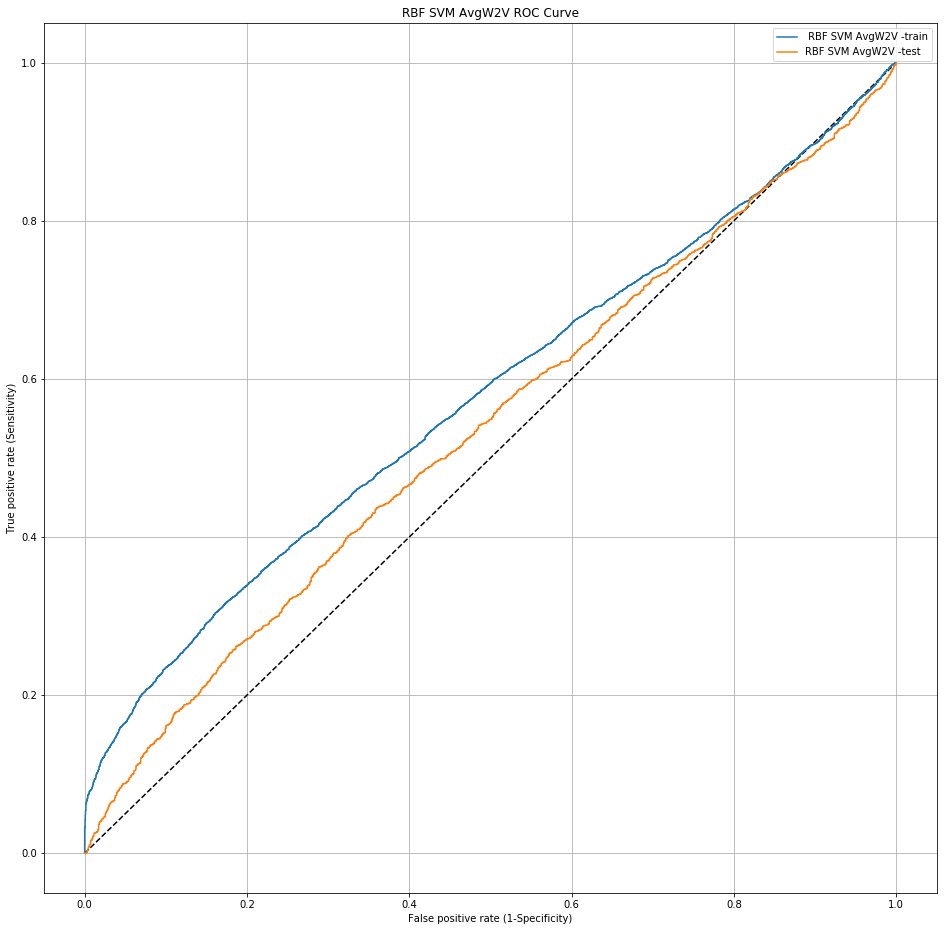

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='RBF SVM AvgW2V ROC Curve'
displaygraph.legnd_1 = ' RBF SVM AvgW2V -train'
displaygraph.legnd_2 = 'RBF SVM AvgW2V -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rbfsvmavgw2v.roc_curve_test['fpr_trn'],rbfsvmavgw2v.roc_curve_test['tpr_trn'],\
                            rbfsvmavgw2v.roc_curve_test['fpr'],rbfsvmavgw2v.roc_curve_test['tpr'])

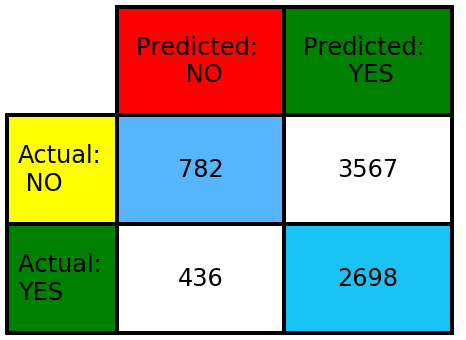

In [0]:
data = [[rbfsvmavgw2v.confsnmtxytstpred['tn'] ,rbfsvmavgw2v.confsnmtxytstpred['fn']],[rbfsvmavgw2v.confsnmtxytstpred['fp'],rbfsvmavgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

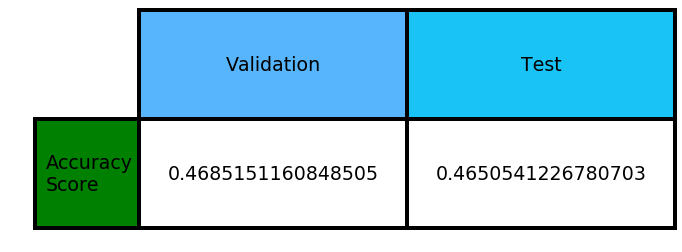

In [0]:
data1= [[rbfsvmavgw2v.accuracy_score_val,rbfsvmavgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision, Recall, f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.18,0.64,0.28], 
         [1,0.86,0.43,0.57]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.18      │ 0.64   │ 0.28      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.86      │ 0.43   │ 0.57      │
╘═══════╧═══════════╧════════╧═══════════╛


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

#### GridsearchCV output for TFIDF Wt W2V using RBF kernel####

0.6715835848921192
{'C': 0.1}
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=100)

In [0]:
rbfsvmtidfwtw2v = assign7RBF()
rbfsvm_wtw2vclf = rbfsvmtidfwtw2v.SVMClasifier()
rbfsvmtidfwtw2v.load_data('WTW2V')

In [0]:
rbfsvmtidfwtw2v.SVM_calcrocaucscore(1000000)

SVC(C=1e-07, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=1e-06, cache_size=200, class_weight={0: 5.14, 1: 1}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=1000, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=100)
[LibSVM]Fitting probability generation and roc auc score generation for training data complete...
[LibSVM]Fitting probability generation and roc auc score generation for validation data complete...
SVC(C=9.999999999999999e-06, cache_size=200, class_weight={0: 5.14, 1: 1},
  coef0=0.0, decision_function_shap

In [0]:
print(rbfsvmtidfwtw2v.rocaucscoretrn)
print(rbfsvmtidfwtw2v.rocaucscoreval)
print(rbfsvmtidfwtw2v.rbf_C)

[0.5304857050933522, 0.5304737369754975, 0.5304773043952427, 0.5304776943819889, 0.5304776176632848, 0.5304776752023128, 0.5492990812960745, 0.5109865148209156, 0.5149120063314412, 0.5045744997819015, 0.500445665345903, 0.5013175925987727, 0.5029250540349013, 0.5028679881054299, 0.5304857050933522, 0.5304737369754975, 0.5304773043952427, 0.5304776943819889, 0.5304776176632848, 0.5304776752023128, 0.5492990812960745, 0.5109865148209156, 0.5149120063314412, 0.5045744997819015, 0.500445665345903, 0.5013175925987727, 0.5029250540349013, 0.5028679881054299]
[0.46928756917103165, 0.530726597647569, 0.5307299853650604, 0.530730703971801, 0.5307304986555894, 0.5307307039718011, 0.5307308066299068, 0.5291844675822128, 0.5272651716361403, 0.5406682139296373, 0.5273763503647237, 0.5328409439946651, 0.514021352064742, 0.5388266301696569, 0.46928756917103165, 0.530726597647569, 0.5307299853650604, 0.530730703971801, 0.5307304986555894, 0.5307307039718011, 0.5307308066299068, 0.5291844675822128, 0.5

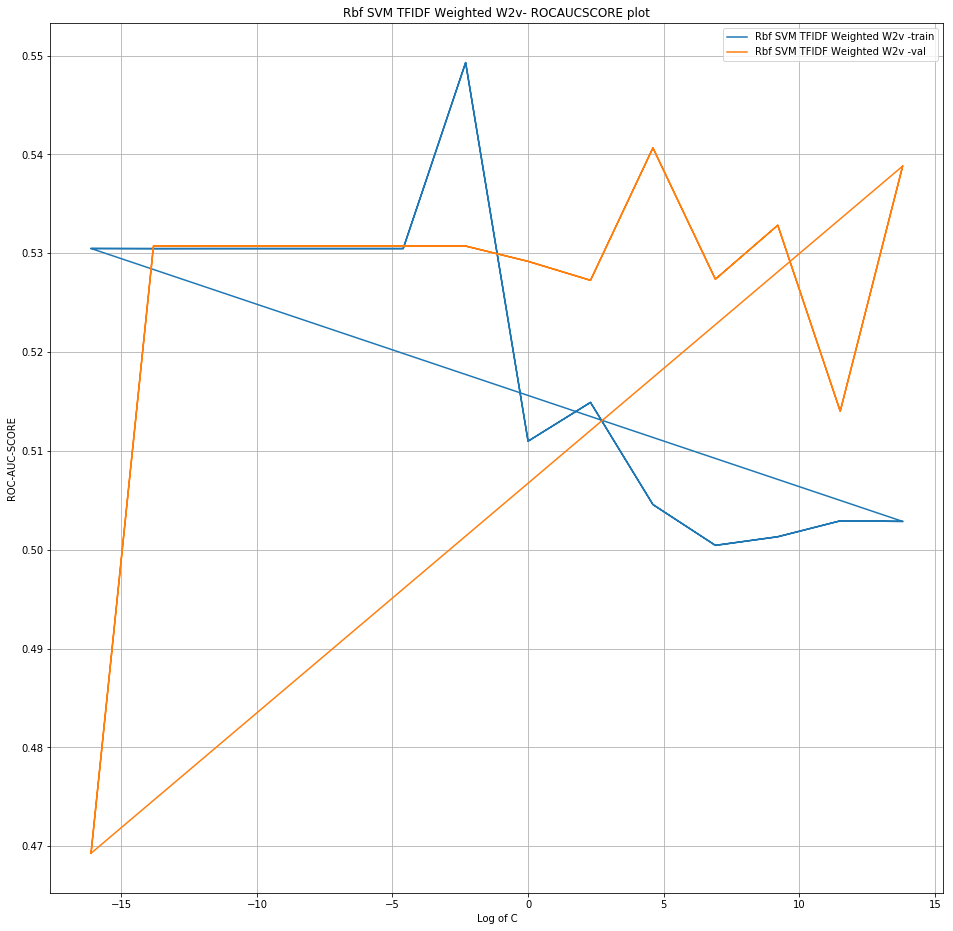

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Rbf SVM TFIDF Weighted W2v- ROCAUCSCORE plot'
displaygraph.legnd_1 = 'Rbf SVM TFIDF Weighted W2v -train'
displaygraph.legnd_2 = 'Rbf SVM TFIDF Weighted W2v -val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='Log of C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = rbfsvmtidfwtw2v.rbf_C
displaygraph.ydatatrn = rbfsvmtidfwtw2v.rocaucscoretrn
displaygraph.ydataval = rbfsvmtidfwtw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

In [0]:
rbfsvmtidfwtw2v.SVM_actualClasifier(0.1)

[LibSVM][LibSVM]***X_test predict [0 1 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.16      0.39      0.23      1218
           1       0.84      0.60      0.70      6265

   micro avg       0.57      0.57      0.57      7483
   macro avg       0.50      0.50      0.47      7483
weighted avg       0.73      0.57      0.62      7483

*** predict probabilities*** [0.493416   0.50410752 0.50410752 ... 0.49491376 0.50410752 0.50084061]


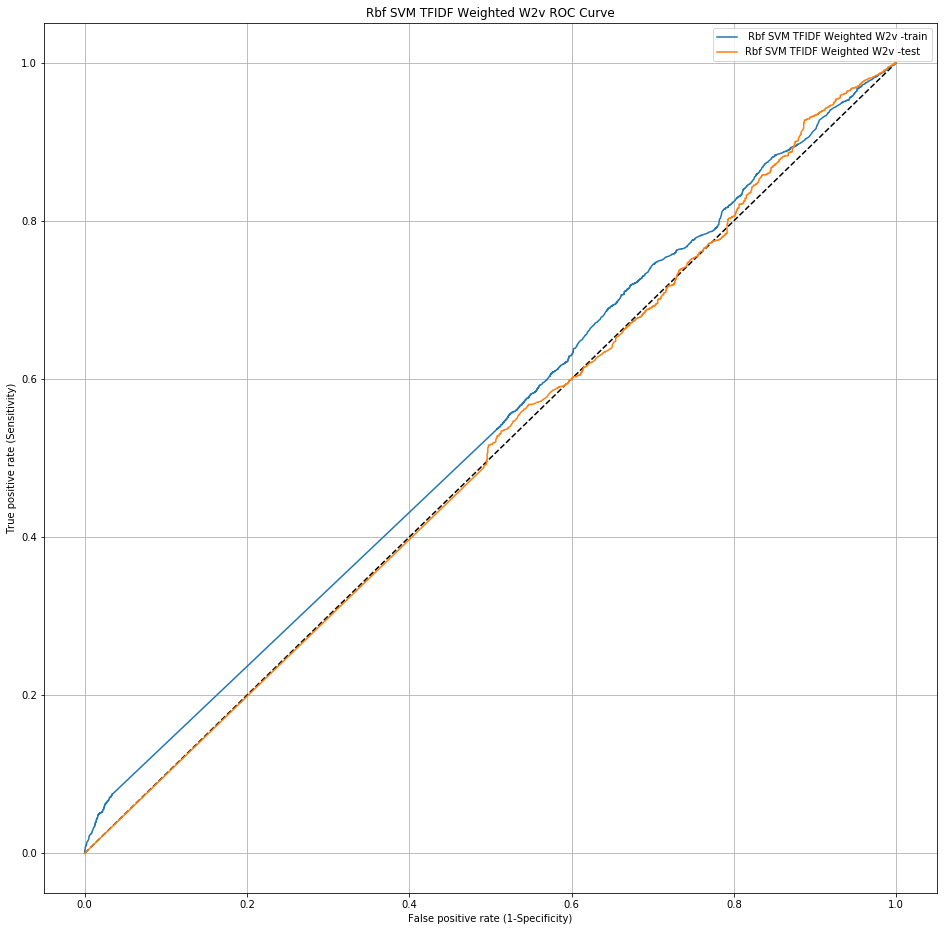

In [0]:
# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Rbf SVM TFIDF Weighted W2v ROC Curve'
displaygraph.legnd_1 = ' Rbf SVM TFIDF Weighted W2v -train'
displaygraph.legnd_2 = 'Rbf SVM TFIDF Weighted W2v -test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(rbfsvmtidfwtw2v.roc_curve_test['fpr_trn'],rbfsvmtidfwtw2v.roc_curve_test['tpr_trn'],\
                            rbfsvmtidfwtw2v.roc_curve_test['fpr'],rbfsvmtidfwtw2v.roc_curve_test['tpr'])

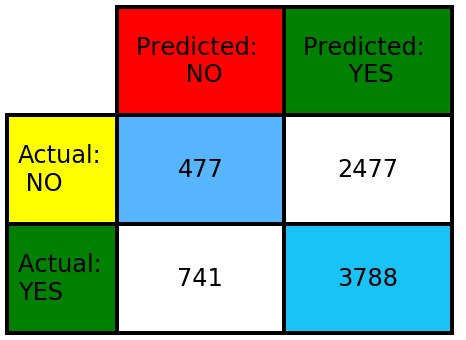

In [0]:
data = [[rbfsvmtidfwtw2v.confsnmtxytstpred['tn'] ,rbfsvmtidfwtw2v.confsnmtxytstpred['fn']],[rbfsvmtidfwtw2v.confsnmtxytstpred['fp'],rbfsvmtidfwtw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

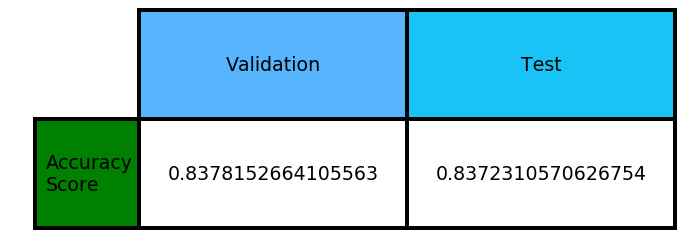

In [0]:
data1= [[rbfsvmtidfwtw2v.accuracy_score_val,rbfsvmtidfwtw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)

#### Precision, Recall, f-1 Score ####

In [0]:
import tabulate
res_tab = [['Label', 'Precision','Recall', 'f-1 Score'],
         [0,0.16,0.39,0.23], 
         [1,0.84,0.60,0.70]]
print(tabulate.tabulate(res_tab, tablefmt='fancy_grid'))

╒═══════╤═══════════╤════════╤═══════════╕
│ Label │ Precision │ Recall │ f-1 Score │
├───────┼───────────┼────────┼───────────┤
│ 0     │ 0.16      │ 0.39   │ 0.23      │
├───────┼───────────┼────────┼───────────┤
│ 1     │ 0.84      │ 0.6    │ 0.7       │
╘═══════╧═══════════╧════════╧═══════════╛


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

### Hyperparameter Details ###

In [0]:
import tabulate
hyprm_tab = [['Classification \nModel', 'Hyper \nParameter','Tf-Idf', 'AvgW2v','WtW2v'],
         ['Linear SVM','Alpha',0.01,0.01,0.0001], 
         ['SVC-RBF Kernel','C',0.1,0.1,0.1]]
         
print(tabulate.tabulate(hyprm_tab, tablefmt='fancy_grid'))

╒═════════════════╤═══════════╤════════╤════════╤════════╕
│ Classification  │ Hyper     │ Tf-Idf │ AvgW2v │ WtW2v  │
│ Model           │ Parameter │        │        │        │
├─────────────────┼───────────┼────────┼────────┼────────┤
│ Linear SVM      │ Alpha     │ 0.01   │ 0.01   │ 0.0001 │
├─────────────────┼───────────┼────────┼────────┼────────┤
│ SVC-RBF Kernel  │ C         │ 0.1    │ 0.1    │ 0.1    │
╘═════════════════╧═══════════╧════════╧════════╧════════╛


### AUC Scores ###

In [0]:
accscore_tab = [['Vectorizer \nType', 'Linear \nSVM','SVC-RBF\nKernel'],
                ['Tf-Idf',0.81,0.93],
                ['AvgW2v',0.56,0.47],
                ['WtW2v',0.51,0.84]]
print(tabulate.tabulate(accscore_tab, tablefmt='fancy_grid'))

╒═════════════╤═════════╤═════════╕
│ Vectorizer  │ Linear  │ SVC-RBF │
│ Type        │ SVM     │ Kernel  │
├─────────────┼─────────┼─────────┤
│ Tf-Idf      │ 0.81    │ 0.93    │
├─────────────┼─────────┼─────────┤
│ AvgW2v      │ 0.56    │ 0.47    │
├─────────────┼─────────┼─────────┤
│ WtW2v       │ 0.51    │ 0.84    │
╘═════════════╧═════════╧═════════╛


## Remarks ##

1. Implementing Linear SVM using the BOW vectorizer with alpha value equal to 0.001(GridsearchCv output) is producing a lower AUC Score This being an imbalanced dataset, precision, re-call and f-1 score are better esitmates of the dataset. Processing the Linear SVM with Alpha equal to 0.1 , we find that precision and recall differ by +0.1/-0.1 but f-1 score differs by +0.03 Please let me know which output I should use to report my results

*   List item
*   List item




---


2. Implementing SVM with RBF kernel without class and sample weights is producing better results when compared to the output generated with class and sample weights. What numbers should I report since this is an imbalanced dataset ?